# Load in model

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict

# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# set seed
torch.manual_seed(0)
np.random.seed(0)

/root/sae-circuits/circuits/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load in Sparse AE's

In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
layers = model.config.num_hidden_layers
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

# Load training data

In [3]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
cfg = dotdict()
cfg.dataset_name="elriggs/openwebtext-100k"
cfg.max_length = 256
cfg.model_batch_size = 64
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset parquet (/root/.cache/huggingface/datasets/elriggs___parquet/elriggs--openwebtext-100k-79076ecafee8a6d5/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Number of tokens: 112754688


## Model Definitions

In [9]:
from torch.optim import Adam
from torch import nn

class two_mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, input_size, bias=False)
        self.linear3 = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x
    
class sparse_two_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        return x
    
class mlp(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.linear2 = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x_hidden = self.relu(x)
        x = self.linear2(x_hidden)
        return x
    
class sae(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x_hidden = self.relu(x)
        x = self.linear2(x_hidden)
        return x, x_hidden
    
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

    
class sparse_nonlinear_no_bias(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x

class linear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
    def forward(self, x):
        x = self.linear(x)
        return x

class linear_no_bias(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, output_size, bias=False)
    def forward(self, x):
        x = self.linear(x)
        return x

## Find Dead Features in Output layers

In [5]:

total_batches = 500
feature_activations = torch.zeros((num_layers, num_features))
norms = torch.zeros((num_layers))
norms_input = torch.zeros((num_layers))
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)

        # Grab intermediate activations in ret
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
    
        for cache_name_ind in range(num_layers):
            #Only find dead features in output layer. This will effect MSE the most
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_cache_name = cache_names[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_activations = ret[output_cache_name].output
            input_activations = ret[input_cache_name].output
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]
            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            output_internal_activations = rearrange(output_activations , "b s n -> (b s) n")
            input_internal_activations = rearrange(input_activations , "b s n -> (b s) n")

            norms[cache_name_ind] += output_internal_activations.norm(dim=1).mean().cpu()
            norms_input[cache_name_ind] += input_internal_activations.norm(dim=1).mean().cpu()

            #Now we have internal activations, run through autoencoder
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            
            feature_activations[cache_name_ind] += output_internal_activations.sum(dim=0).cpu()
        if i > total_batches:
            break
    alive_features_ind = (feature_activations != 0)
    alive_features_ind = alive_features_ind
    norms = norms/total_batches
    norms_input = norms_input/total_batches
normalization_per_layer = (norms/norms.min())**2
normalization_per_layer_input = (norms_input/norms_input.min())**2
print(f"Norms: {norms}")
print(f"Alive features: {alive_features_ind.sum(dim=1)} / {num_features}")
print(f"Norms input: {norms_input}")

  0%|          | 0/6882 [00:00<?, ?it/s]

  7%|▋         | 501/6882 [01:08<14:26,  7.36it/s]

Norms: tensor([ 4.2565,  6.8754,  9.6665, 13.1211, 54.1252])
Alive features: tensor([1243, 1022, 1680, 1769, 1350]) / 3072
Norms input: tensor([ 7.1538,  9.0301, 13.1636, 15.0927, 16.4025])


In [6]:
# Save the normalization per layer
torch.save(normalization_per_layer, "normalization_per_layer.pt")

In [10]:
initialize_weights = False
two_mlp_weights = []
two_nonlinear_weights = []
mlp_weights = []
nonlinear_weights = []
linear_weights = []
mlp_weights_no_bias = []
nonlinear_weights_no_bias = []
linear_weights_no_bias = []

two_mlp_optimizers = []
two_nonlinear_optimizers = []
mlp_optimizers = []
nonlinear_optimizers = []
linear_optimizers = []
mlp_optimizers_no_bias = []
nonlinear_optimizers_no_bias = []
linear_optimizers_no_bias = []
for auto_ind in range(len(autoencoders)//2):
    two_mlp_weights.append(two_mlp(num_features))
    two_mlp_weights[-1].to(device)
    two_mlp_optimizers.append(Adam(two_mlp_weights[-1].parameters(), lr=1e-3))

    # two_nonlinear_weights.append(sparse_two_nonlinear(num_features))
    # two_nonlinear_weights[-1].to(device)
    # two_nonlinear_optimizers.append(Adam(two_nonlinear_weights[-1].parameters(), lr=1e-3))

    # mlp_weights.append(mlp(num_features))
    # mlp_weights[-1].to(device)
    # mlp_optimizers.append(Adam(mlp_weights[-1].parameters(), lr=1e-3))

    mlp_weights_no_bias.append(mlp_no_bias(num_features))
    mlp_weights_no_bias[-1].to(device)
    mlp_optimizers_no_bias.append(Adam(mlp_weights_no_bias[-1].parameters(), lr=1e-3))

    # nonlinear_weights.append(sparse_nonlinear(num_features))
    # nonlinear_weights[-1].to(device)
    # nonlinear_optimizers.append(Adam(nonlinear_weights[-1].parameters(), lr=1e-3))

    # nonlinear_weights_no_bias.append(sparse_nonlinear_no_bias(num_features))
    # nonlinear_weights_no_bias[-1].to(device)
    # nonlinear_optimizers_no_bias.append(Adam(nonlinear_weights_no_bias[-1].parameters(), lr=1e-3))

    # linear_weights.append(linear(num_features))
    # linear_weights[-1].to(device)
    # linear_optimizers.append(Adam(linear_weights[-1].parameters(), lr=1e-3))

    linear_weights_no_bias.append(linear_no_bias(num_features))
    linear_weights_no_bias[-1].to(device)
    linear_optimizers_no_bias.append(Adam(linear_weights_no_bias[-1].parameters(), lr=1e-3))

    if(initialize_weights): #Note this doesn't work,
        # Multiply the decoder weights by mlp weights & second autoencoder's encoder weights
        decoder = autoencoders[auto_ind].encoder
        mlp_enc = model.gpt_neox.layers[auto_ind+1].mlp.dense_h_to_4h.weight.detach().T
        mlp_dec = model.gpt_neox.layers[auto_ind+1].mlp.dense_4h_to_h.weight.detach().T
        encoder = autoencoders[auto_ind+1].encoder.T
        initial_weights = decoder @ mlp_enc @ mlp_dec @ encoder
        nonlinear_weights[-1].linear.weight.data = initial_weights
        linear_weights[-1].linear.weight.data = initial_weights

## Train the model

In [13]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    l1_alpha = 1e-3
    batch_size = 32
    losses = [[] for _ in range(len(sparse_weights))]
    
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            input_feature_activations = input_autoencoder.encode(input_internal_activations)
            output_feature_activations = output_autoencoder.encode(output_internal_activations)

            res_reconstruction = input_autoencoder.decode(input_feature_activations)
            residual_loss = input_internal_activations - res_reconstruction
            residual_norm = residual_loss.norm(dim=1).mean()

            x_hat = sparse_weights[cache_name_ind](input_feature_activations)

            # loss = mse(x_hat, output_internal_activations)
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
            indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind.to(device))
            indexed_output_internal_activations = output_feature_activations.index_select(dim=1, index=current_alive_features_ind.to(device))
            loss = mse(indexed_x_hat, indexed_output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha * l1_loss

            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind].append(loss.item())

            if i % 100 == 0:
                print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")
            
        if i > 4000:
            # Stop training after 1000 batches
            break
    return losses
# two_mlp_losses = train_sparse_model(model, dataset, device, two_mlp_weights, autoencoders, cache_names, two_mlp_optimizers)
# two_nonlinear_losses = train_sparse_model(model, dataset, device, two_nonlinear_weights, autoencoders, cache_names, two_nonlinear_optimizers)
# mlp_losses = train_sparse_model(model, dataset, device, mlp_weights, autoencoders, cache_names, mlp_optimizers)

# nonlinear_losses = train_sparse_model(model, dataset, device, nonlinear_weights, autoencoders, cache_names, nonlinear_optimizers)
# linear_losses = train_sparse_model(model, dataset, device, linear_weights, autoencoders, cache_names, linear_optimizers)

mlp_losses_no_bias = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)
# nonlinear_losses_no_bias = train_sparse_model(model, dataset, device, nonlinear_weights_no_bias, autoencoders, cache_names, nonlinear_optimizers_no_bias)
linear_losses_no_bias = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias)

  0%|          | 0/6882 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.0039290268905460835 | L1 Loss: 27.712543487548828
Layers: 1 | MSE Loss: 0.04742790013551712 | L1 Loss: 27.707237243652344
Layers: 2 | MSE Loss: 0.018408894538879395 | L1 Loss: 27.71710205078125


  0%|          | 1/6882 [00:00<1:07:44,  1.69it/s]

Layers: 3 | MSE Loss: 0.04844953119754791 | L1 Loss: 27.718481063842773
Layers: 4 | MSE Loss: 2.2304840087890625 | L1 Loss: 27.712804794311523


  1%|▏         | 100/6882 [00:54<1:01:12,  1.85it/s]

Layers: 0 | MSE Loss: 0.0010276122484356165 | L1 Loss: 30.10164451599121
Layers: 1 | MSE Loss: 0.0027579818852245808 | L1 Loss: 38.38920211791992
Layers: 2 | MSE Loss: 0.002790031023323536 | L1 Loss: 34.021461486816406


  1%|▏         | 101/6882 [00:54<1:01:13,  1.85it/s]

Layers: 3 | MSE Loss: 0.004135184921324253 | L1 Loss: 37.7050895690918
Layers: 4 | MSE Loss: 0.06425680220127106 | L1 Loss: 53.34124755859375


  3%|▎         | 200/6882 [01:48<1:00:23,  1.84it/s]

Layers: 0 | MSE Loss: 0.0008367157424800098 | L1 Loss: 32.67396545410156
Layers: 1 | MSE Loss: 0.002301029395312071 | L1 Loss: 41.017112731933594
Layers: 2 | MSE Loss: 0.0024209467228502035 | L1 Loss: 36.281578063964844


  3%|▎         | 201/6882 [01:48<1:00:32,  1.84it/s]

Layers: 3 | MSE Loss: 0.003466924885287881 | L1 Loss: 42.384918212890625
Layers: 4 | MSE Loss: 0.03945964202284813 | L1 Loss: 53.215972900390625


  4%|▍         | 300/6882 [02:42<59:36,  1.84it/s]  

Layers: 0 | MSE Loss: 0.0006781757110729814 | L1 Loss: 34.50839614868164
Layers: 1 | MSE Loss: 0.0019154025940224528 | L1 Loss: 43.10557174682617
Layers: 2 | MSE Loss: 0.0021741376258432865 | L1 Loss: 38.076988220214844


  4%|▍         | 301/6882 [02:43<59:33,  1.84it/s]

Layers: 3 | MSE Loss: 0.002987134037539363 | L1 Loss: 45.1380729675293
Layers: 4 | MSE Loss: 0.027234666049480438 | L1 Loss: 54.79179382324219


  6%|▌         | 400/6882 [03:36<58:33,  1.84it/s]

Layers: 0 | MSE Loss: 0.0006500495946966112 | L1 Loss: 35.930912017822266
Layers: 1 | MSE Loss: 0.0018209778936579823 | L1 Loss: 44.68201446533203
Layers: 2 | MSE Loss: 0.0022047797683626413 | L1 Loss: 39.55564498901367


  6%|▌         | 401/6882 [03:37<58:37,  1.84it/s]

Layers: 3 | MSE Loss: 0.002995698479935527 | L1 Loss: 47.095726013183594
Layers: 4 | MSE Loss: 0.032069556415081024 | L1 Loss: 56.57880401611328


  7%|▋         | 500/6882 [04:31<57:46,  1.84it/s]

Layers: 0 | MSE Loss: 0.0006171257118694484 | L1 Loss: 37.074501037597656
Layers: 1 | MSE Loss: 0.0016440872568637133 | L1 Loss: 46.24827194213867
Layers: 2 | MSE Loss: 0.0021179805044084787 | L1 Loss: 40.865352630615234


  7%|▋         | 501/6882 [04:31<57:45,  1.84it/s]

Layers: 3 | MSE Loss: 0.002756639616563916 | L1 Loss: 48.66401290893555
Layers: 4 | MSE Loss: 0.0238092839717865 | L1 Loss: 58.32274627685547


  9%|▊         | 600/6882 [05:25<56:54,  1.84it/s]

Layers: 0 | MSE Loss: 0.0006015931721776724 | L1 Loss: 38.06841278076172
Layers: 1 | MSE Loss: 0.0015407754108309746 | L1 Loss: 47.631805419921875
Layers: 2 | MSE Loss: 0.0020156146492809057 | L1 Loss: 42.01960754394531


  9%|▊         | 601/6882 [05:26<56:57,  1.84it/s]

Layers: 3 | MSE Loss: 0.002615549834445119 | L1 Loss: 49.906455993652344
Layers: 4 | MSE Loss: 0.020703935995697975 | L1 Loss: 60.04001998901367


 10%|█         | 700/6882 [06:19<55:58,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005761810461990535 | L1 Loss: 38.96183776855469
Layers: 1 | MSE Loss: 0.001511824200861156 | L1 Loss: 48.91624069213867
Layers: 2 | MSE Loss: 0.0020230873487889767 | L1 Loss: 43.109832763671875


 10%|█         | 701/6882 [06:20<55:56,  1.84it/s]

Layers: 3 | MSE Loss: 0.002543616108596325 | L1 Loss: 50.997798919677734
Layers: 4 | MSE Loss: 0.01937161199748516 | L1 Loss: 61.53253173828125


 12%|█▏        | 800/6882 [07:14<54:57,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005748621770180762 | L1 Loss: 39.75240707397461
Layers: 1 | MSE Loss: 0.0014647895004600286 | L1 Loss: 50.1185417175293
Layers: 2 | MSE Loss: 0.0018954984843730927 | L1 Loss: 44.05552291870117


 12%|█▏        | 801/6882 [07:14<54:58,  1.84it/s]

Layers: 3 | MSE Loss: 0.002525725867599249 | L1 Loss: 51.99009323120117
Layers: 4 | MSE Loss: 0.019669830799102783 | L1 Loss: 62.840267181396484


 13%|█▎        | 900/6882 [08:08<54:01,  1.85it/s]

Layers: 0 | MSE Loss: 0.000542620022315532 | L1 Loss: 40.482669830322266
Layers: 1 | MSE Loss: 0.0014193952083587646 | L1 Loss: 51.34649658203125
Layers: 2 | MSE Loss: 0.0018355903448536992 | L1 Loss: 44.97982406616211


 13%|█▎        | 901/6882 [08:08<54:00,  1.85it/s]

Layers: 3 | MSE Loss: 0.0023901727981865406 | L1 Loss: 52.89852523803711
Layers: 4 | MSE Loss: 0.01812366396188736 | L1 Loss: 64.03128051757812


 15%|█▍        | 1000/6882 [09:02<53:13,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005543852457776666 | L1 Loss: 41.198001861572266
Layers: 1 | MSE Loss: 0.0013115883339196444 | L1 Loss: 52.46992111206055
Layers: 2 | MSE Loss: 0.001801788341253996 | L1 Loss: 45.911705017089844


 15%|█▍        | 1001/6882 [09:02<53:11,  1.84it/s]

Layers: 3 | MSE Loss: 0.0023010512813925743 | L1 Loss: 53.783607482910156
Layers: 4 | MSE Loss: 0.016969699412584305 | L1 Loss: 65.24508666992188


 16%|█▌        | 1100/6882 [09:56<52:05,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005400179070420563 | L1 Loss: 41.85675811767578
Layers: 1 | MSE Loss: 0.0013841177569702268 | L1 Loss: 53.537841796875
Layers: 2 | MSE Loss: 0.001907424652017653 | L1 Loss: 46.76567840576172


 16%|█▌        | 1101/6882 [09:57<52:07,  1.85it/s]

Layers: 3 | MSE Loss: 0.0023907022550702095 | L1 Loss: 54.562374114990234
Layers: 4 | MSE Loss: 0.018282588571310043 | L1 Loss: 66.28614044189453


 17%|█▋        | 1200/6882 [10:50<51:17,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005376439657993615 | L1 Loss: 42.46445846557617
Layers: 1 | MSE Loss: 0.0012021653819829226 | L1 Loss: 54.59449005126953
Layers: 2 | MSE Loss: 0.0018306898418813944 | L1 Loss: 47.61152267456055


 17%|█▋        | 1201/6882 [10:51<51:16,  1.85it/s]

Layers: 3 | MSE Loss: 0.0023592764046043158 | L1 Loss: 55.26341247558594
Layers: 4 | MSE Loss: 0.017811745405197144 | L1 Loss: 67.26162719726562


 19%|█▉        | 1300/6882 [11:44<50:22,  1.85it/s]

Layers: 0 | MSE Loss: 0.000542350229807198 | L1 Loss: 43.03150939941406
Layers: 1 | MSE Loss: 0.001246115774847567 | L1 Loss: 55.6317138671875
Layers: 2 | MSE Loss: 0.001824994687922299 | L1 Loss: 48.3939208984375


 19%|█▉        | 1301/6882 [11:45<50:25,  1.84it/s]

Layers: 3 | MSE Loss: 0.0023066094145178795 | L1 Loss: 55.95734786987305
Layers: 4 | MSE Loss: 0.017012830823659897 | L1 Loss: 68.20510864257812


 20%|██        | 1400/6882 [12:39<49:35,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005275275907479227 | L1 Loss: 43.60521697998047
Layers: 1 | MSE Loss: 0.0012478975113481283 | L1 Loss: 56.57441329956055
Layers: 2 | MSE Loss: 0.001765401684679091 | L1 Loss: 49.18668746948242


 20%|██        | 1401/6882 [12:39<49:33,  1.84it/s]

Layers: 3 | MSE Loss: 0.0022187838330864906 | L1 Loss: 56.646949768066406
Layers: 4 | MSE Loss: 0.01593921147286892 | L1 Loss: 69.144775390625


 22%|██▏       | 1500/6882 [13:33<48:42,  1.84it/s]

Layers: 0 | MSE Loss: 0.0006266697309911251 | L1 Loss: 44.175933837890625
Layers: 1 | MSE Loss: 0.0012051271041855216 | L1 Loss: 57.580406188964844
Layers: 2 | MSE Loss: 0.0017013922333717346 | L1 Loss: 50.00393295288086


 22%|██▏       | 1501/6882 [13:33<48:40,  1.84it/s]

Layers: 3 | MSE Loss: 0.0021692391019314528 | L1 Loss: 57.30474090576172
Layers: 4 | MSE Loss: 0.014671467244625092 | L1 Loss: 70.07625579833984


 23%|██▎       | 1600/6882 [14:27<47:49,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005107626202516258 | L1 Loss: 44.678436279296875
Layers: 1 | MSE Loss: 0.0011587117332965136 | L1 Loss: 58.547393798828125
Layers: 2 | MSE Loss: 0.001676818705163896 | L1 Loss: 50.78443908691406


 23%|██▎       | 1601/6882 [14:28<47:48,  1.84it/s]

Layers: 3 | MSE Loss: 0.002146851969882846 | L1 Loss: 57.940879821777344
Layers: 4 | MSE Loss: 0.01591460034251213 | L1 Loss: 70.90875244140625


 25%|██▍       | 1700/6882 [15:21<46:44,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005077678360976279 | L1 Loss: 45.17768096923828
Layers: 1 | MSE Loss: 0.0012196894967928529 | L1 Loss: 59.42615509033203
Layers: 2 | MSE Loss: 0.0017288707895204425 | L1 Loss: 51.545928955078125


 25%|██▍       | 1701/6882 [15:22<46:41,  1.85it/s]

Layers: 3 | MSE Loss: 0.0021735429763793945 | L1 Loss: 58.52614974975586
Layers: 4 | MSE Loss: 0.016564371064305305 | L1 Loss: 71.74539184570312


 26%|██▌       | 1800/6882 [16:15<45:55,  1.84it/s]

Layers: 0 | MSE Loss: 0.0005023261182941496 | L1 Loss: 45.686058044433594
Layers: 1 | MSE Loss: 0.0011790490243583918 | L1 Loss: 60.352691650390625
Layers: 2 | MSE Loss: 0.0018591574626043439 | L1 Loss: 52.85236740112305


 26%|██▌       | 1801/6882 [16:16<45:59,  1.84it/s]

Layers: 3 | MSE Loss: 0.002115381881594658 | L1 Loss: 59.13330078125
Layers: 4 | MSE Loss: 0.01656768098473549 | L1 Loss: 72.53099822998047


 28%|██▊       | 1900/6882 [17:10<44:49,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005279229371808469 | L1 Loss: 46.128509521484375
Layers: 1 | MSE Loss: 0.0011639856966212392 | L1 Loss: 61.250152587890625
Layers: 2 | MSE Loss: 0.0016662409761920571 | L1 Loss: 53.090850830078125


 28%|██▊       | 1901/6882 [17:10<44:50,  1.85it/s]

Layers: 3 | MSE Loss: 0.0021102719474583864 | L1 Loss: 59.67113494873047
Layers: 4 | MSE Loss: 0.014931788668036461 | L1 Loss: 73.34168243408203


 29%|██▉       | 2000/6882 [18:04<44:00,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005244740168564022 | L1 Loss: 46.57042694091797
Layers: 1 | MSE Loss: 0.0011652254033833742 | L1 Loss: 62.121986389160156
Layers: 2 | MSE Loss: 0.00171441282145679 | L1 Loss: 53.69266891479492


 29%|██▉       | 2001/6882 [18:04<43:59,  1.85it/s]

Layers: 3 | MSE Loss: 0.0021717750933021307 | L1 Loss: 60.199066162109375
Layers: 4 | MSE Loss: 0.016232093796133995 | L1 Loss: 74.14447021484375


 31%|███       | 2100/6882 [18:58<42:57,  1.86it/s]

Layers: 0 | MSE Loss: 0.000504877942148596 | L1 Loss: 47.0024528503418
Layers: 1 | MSE Loss: 0.0011196443811058998 | L1 Loss: 62.94393539428711
Layers: 2 | MSE Loss: 0.0018031198997050524 | L1 Loss: 57.584068298339844


 31%|███       | 2101/6882 [18:58<43:00,  1.85it/s]

Layers: 3 | MSE Loss: 0.0021413571666926146 | L1 Loss: 60.74103546142578
Layers: 4 | MSE Loss: 0.015240458771586418 | L1 Loss: 75.0107192993164


 32%|███▏      | 2200/6882 [19:52<42:10,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004810742393601686 | L1 Loss: 47.44334030151367
Layers: 1 | MSE Loss: 0.0011383481323719025 | L1 Loss: 63.74646759033203
Layers: 2 | MSE Loss: 0.0016985188703984022 | L1 Loss: 57.247650146484375


 32%|███▏      | 2201/6882 [19:52<42:09,  1.85it/s]

Layers: 3 | MSE Loss: 0.0020566019229590893 | L1 Loss: 61.24613571166992
Layers: 4 | MSE Loss: 0.014029290527105331 | L1 Loss: 75.70733642578125


 33%|███▎      | 2300/6882 [20:46<41:17,  1.85it/s]

Layers: 0 | MSE Loss: 0.00048716412857174873 | L1 Loss: 47.84959030151367
Layers: 1 | MSE Loss: 0.001082135713659227 | L1 Loss: 64.5566635131836
Layers: 2 | MSE Loss: 0.0016042767092585564 | L1 Loss: 57.34995651245117


 33%|███▎      | 2301/6882 [20:46<41:18,  1.85it/s]

Layers: 3 | MSE Loss: 0.0020147187169641256 | L1 Loss: 61.79254150390625
Layers: 4 | MSE Loss: 0.014141923747956753 | L1 Loss: 76.40321350097656


 35%|███▍      | 2400/6882 [21:40<40:20,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005096084205433726 | L1 Loss: 48.2507438659668
Layers: 1 | MSE Loss: 0.001114290556870401 | L1 Loss: 65.34095764160156
Layers: 2 | MSE Loss: 0.002634890377521515 | L1 Loss: 69.39576721191406


 35%|███▍      | 2401/6882 [21:40<40:21,  1.85it/s]

Layers: 3 | MSE Loss: 0.002070083050057292 | L1 Loss: 62.323028564453125
Layers: 4 | MSE Loss: 0.01421133242547512 | L1 Loss: 77.2843017578125


 36%|███▋      | 2500/6882 [22:34<39:27,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005075116641819477 | L1 Loss: 48.67382049560547
Layers: 1 | MSE Loss: 0.0011115990346297622 | L1 Loss: 66.11425018310547
Layers: 2 | MSE Loss: 0.0019346554763615131 | L1 Loss: 70.25401306152344


 36%|███▋      | 2501/6882 [22:34<39:28,  1.85it/s]

Layers: 3 | MSE Loss: 0.0020866352133452892 | L1 Loss: 62.83306121826172
Layers: 4 | MSE Loss: 0.014236649498343468 | L1 Loss: 77.94116973876953


 38%|███▊      | 2600/6882 [23:28<38:31,  1.85it/s]

Layers: 0 | MSE Loss: 0.00048514269292354584 | L1 Loss: 49.06964111328125
Layers: 1 | MSE Loss: 0.0010924555826932192 | L1 Loss: 66.89892578125
Layers: 2 | MSE Loss: 0.00223281467333436 | L1 Loss: 76.0671615600586


 38%|███▊      | 2601/6882 [23:28<38:31,  1.85it/s]

Layers: 3 | MSE Loss: 0.0019656014628708363 | L1 Loss: 63.324851989746094
Layers: 4 | MSE Loss: 0.013825856149196625 | L1 Loss: 78.85673522949219


 39%|███▉      | 2700/6882 [24:22<37:40,  1.85it/s]

Layers: 0 | MSE Loss: 0.000514125800691545 | L1 Loss: 49.44812774658203
Layers: 1 | MSE Loss: 0.001133648562245071 | L1 Loss: 67.59158325195312
Layers: 2 | MSE Loss: 0.004172328393906355 | L1 Loss: 76.1519775390625


 39%|███▉      | 2701/6882 [24:22<37:37,  1.85it/s]

Layers: 3 | MSE Loss: 0.0020013125613331795 | L1 Loss: 63.80873107910156
Layers: 4 | MSE Loss: 0.01607019081711769 | L1 Loss: 79.5765609741211


 41%|████      | 2800/6882 [25:16<36:37,  1.86it/s]

Layers: 0 | MSE Loss: 0.0005068204482086003 | L1 Loss: 49.81041717529297
Layers: 1 | MSE Loss: 0.001083449344150722 | L1 Loss: 68.33919525146484
Layers: 2 | MSE Loss: 0.002034951001405716 | L1 Loss: 76.40058898925781


 41%|████      | 2801/6882 [25:16<36:39,  1.86it/s]

Layers: 3 | MSE Loss: 0.001966173993423581 | L1 Loss: 64.29448699951172
Layers: 4 | MSE Loss: 0.01408839225769043 | L1 Loss: 80.29098510742188


 42%|████▏     | 2900/6882 [26:10<36:06,  1.84it/s]

Layers: 0 | MSE Loss: 0.0004982230602763593 | L1 Loss: 50.184444427490234
Layers: 1 | MSE Loss: 0.0010479622287675738 | L1 Loss: 69.09205627441406
Layers: 2 | MSE Loss: 0.0018928933423012495 | L1 Loss: 76.3571548461914


 42%|████▏     | 2901/6882 [26:10<36:19,  1.83it/s]

Layers: 3 | MSE Loss: 0.0020193157251924276 | L1 Loss: 64.77934265136719
Layers: 4 | MSE Loss: 0.013975197449326515 | L1 Loss: 81.03003692626953


 44%|████▎     | 3000/6882 [27:04<34:58,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004686279280576855 | L1 Loss: 50.55615234375
Layers: 1 | MSE Loss: 0.001052645267918706 | L1 Loss: 69.75942993164062
Layers: 2 | MSE Loss: 0.0018417941173538566 | L1 Loss: 76.3908920288086


 44%|████▎     | 3001/6882 [27:05<34:56,  1.85it/s]

Layers: 3 | MSE Loss: 0.001954867970198393 | L1 Loss: 65.23908996582031
Layers: 4 | MSE Loss: 0.013828267343342304 | L1 Loss: 81.69007873535156


 45%|████▌     | 3100/6882 [27:58<34:01,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004816576256416738 | L1 Loss: 50.90473937988281
Layers: 1 | MSE Loss: 0.0010714526288211346 | L1 Loss: 70.44786071777344
Layers: 2 | MSE Loss: 0.0019671127665787935 | L1 Loss: 78.03826904296875


 45%|████▌     | 3101/6882 [27:59<34:01,  1.85it/s]

Layers: 3 | MSE Loss: 0.0019478399772197008 | L1 Loss: 65.74056243896484
Layers: 4 | MSE Loss: 0.013852404430508614 | L1 Loss: 82.47412872314453


 46%|████▋     | 3200/6882 [28:52<33:03,  1.86it/s]

Layers: 0 | MSE Loss: 0.0004947715206071734 | L1 Loss: 51.26801681518555
Layers: 1 | MSE Loss: 0.0010327722411602736 | L1 Loss: 71.13306427001953
Layers: 2 | MSE Loss: 0.004137604031711817 | L1 Loss: 78.02381896972656


 47%|████▋     | 3201/6882 [28:52<33:03,  1.86it/s]

Layers: 3 | MSE Loss: 0.0019425611244514585 | L1 Loss: 66.23556518554688
Layers: 4 | MSE Loss: 0.013428406789898872 | L1 Loss: 83.20878601074219


 48%|████▊     | 3300/6882 [29:46<32:09,  1.86it/s]

Layers: 0 | MSE Loss: 0.0004893554141744971 | L1 Loss: 51.611778259277344
Layers: 1 | MSE Loss: 0.0010126247070729733 | L1 Loss: 71.81085205078125
Layers: 2 | MSE Loss: 0.0023497617803514004 | L1 Loss: 82.57469177246094


 48%|████▊     | 3301/6882 [29:46<32:08,  1.86it/s]

Layers: 3 | MSE Loss: 0.0018684286624193192 | L1 Loss: 66.66508483886719
Layers: 4 | MSE Loss: 0.012336875312030315 | L1 Loss: 84.07140350341797


 49%|████▉     | 3400/6882 [30:40<31:20,  1.85it/s]

Layers: 0 | MSE Loss: 0.0005026821163482964 | L1 Loss: 51.96283721923828
Layers: 1 | MSE Loss: 0.0010421016486361623 | L1 Loss: 72.4953842163086
Layers: 2 | MSE Loss: 0.002054082229733467 | L1 Loss: 82.86113739013672


 49%|████▉     | 3401/6882 [30:40<31:19,  1.85it/s]

Layers: 3 | MSE Loss: 0.0018605801742523909 | L1 Loss: 67.12467956542969
Layers: 4 | MSE Loss: 0.01289069838821888 | L1 Loss: 84.70074462890625


 51%|█████     | 3500/6882 [31:34<30:24,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004619112587533891 | L1 Loss: 52.30448532104492
Layers: 1 | MSE Loss: 0.0010068630799651146 | L1 Loss: 73.18218231201172
Layers: 2 | MSE Loss: 0.002038426697254181 | L1 Loss: 83.30135345458984


 51%|█████     | 3501/6882 [31:34<30:24,  1.85it/s]

Layers: 3 | MSE Loss: 0.0018923002062365413 | L1 Loss: 67.60470581054688
Layers: 4 | MSE Loss: 0.01420486718416214 | L1 Loss: 85.4251708984375


 52%|█████▏    | 3600/6882 [32:28<29:30,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004993975744582713 | L1 Loss: 52.65681457519531
Layers: 1 | MSE Loss: 0.0010869482066482306 | L1 Loss: 73.87005615234375
Layers: 2 | MSE Loss: 0.0020408437121659517 | L1 Loss: 83.38398742675781


 52%|█████▏    | 3601/6882 [32:28<29:29,  1.85it/s]

Layers: 3 | MSE Loss: 0.0019798055291175842 | L1 Loss: 68.03852844238281
Layers: 4 | MSE Loss: 0.014151622541248798 | L1 Loss: 86.2203598022461


 54%|█████▍    | 3700/6882 [33:22<28:36,  1.85it/s]

Layers: 0 | MSE Loss: 0.0004636158118955791 | L1 Loss: 52.98789978027344
Layers: 1 | MSE Loss: 0.0010340523440390825 | L1 Loss: 74.49522399902344
Layers: 2 | MSE Loss: 0.0019149471772834659 | L1 Loss: 83.40103149414062


 54%|█████▍    | 3701/6882 [33:22<28:41,  1.85it/s]

Layers: 3 | MSE Loss: 0.0018313464242964983 | L1 Loss: 68.49700927734375
Layers: 4 | MSE Loss: 0.012797634117305279 | L1 Loss: 86.84623718261719


 55%|█████▌    | 3800/6882 [34:16<27:38,  1.86it/s]

Layers: 0 | MSE Loss: 0.0004692205402534455 | L1 Loss: 53.30149459838867
Layers: 1 | MSE Loss: 0.001017864909954369 | L1 Loss: 75.11458587646484
Layers: 2 | MSE Loss: 0.0019751565996557474 | L1 Loss: 83.509765625


 55%|█████▌    | 3801/6882 [34:16<27:38,  1.86it/s]

Layers: 3 | MSE Loss: 0.0019394143018871546 | L1 Loss: 68.94646453857422
Layers: 4 | MSE Loss: 0.01326180063188076 | L1 Loss: 87.46727752685547


 57%|█████▋    | 3900/6882 [35:10<26:45,  1.86it/s]

Layers: 0 | MSE Loss: 0.0004738419665955007 | L1 Loss: 53.63050842285156
Layers: 1 | MSE Loss: 0.0010854059364646673 | L1 Loss: 75.73216247558594
Layers: 2 | MSE Loss: 0.0019041660707443953 | L1 Loss: 83.65060424804688


 57%|█████▋    | 3901/6882 [35:10<26:46,  1.86it/s]

Layers: 3 | MSE Loss: 0.001871469896286726 | L1 Loss: 69.39717102050781
Layers: 4 | MSE Loss: 0.013008806854486465 | L1 Loss: 88.1139144897461


 58%|█████▊    | 4000/6882 [36:03<25:50,  1.86it/s]

Layers: 0 | MSE Loss: 0.0004863125504925847 | L1 Loss: 53.94169616699219
Layers: 1 | MSE Loss: 0.001011448330245912 | L1 Loss: 76.3556137084961
Layers: 2 | MSE Loss: 0.0019735945388674736 | L1 Loss: 83.76216125488281


 58%|█████▊    | 4001/6882 [36:04<25:49,  1.86it/s]

Layers: 3 | MSE Loss: 0.001959589309990406 | L1 Loss: 69.83401489257812
Layers: 4 | MSE Loss: 0.01414494588971138 | L1 Loss: 88.80087280273438


  0%|          | 1/6882 [00:00<39:49,  2.88it/s]

Layers: 0 | MSE Loss: 0.005713282153010368 | L1 Loss: 27.714553833007812
Layers: 1 | MSE Loss: 0.046854447573423386 | L1 Loss: 27.71187973022461
Layers: 2 | MSE Loss: 0.028992367908358574 | L1 Loss: 27.726600646972656
Layers: 3 | MSE Loss: 0.06229102611541748 | L1 Loss: 27.705150604248047
Layers: 4 | MSE Loss: 2.2086563110351562 | L1 Loss: 27.708511352539062


  1%|▏         | 101/6882 [00:32<35:53,  3.15it/s]

Layers: 0 | MSE Loss: 0.002600139705464244 | L1 Loss: 19.00136375427246
Layers: 1 | MSE Loss: 0.03640199825167656 | L1 Loss: 21.055400848388672
Layers: 2 | MSE Loss: 0.007715118583291769 | L1 Loss: 18.944255828857422
Layers: 3 | MSE Loss: 0.01868063025176525 | L1 Loss: 21.361312866210938
Layers: 4 | MSE Loss: 1.9570266008377075 | L1 Loss: 20.380367279052734


  3%|▎         | 201/6882 [01:03<35:22,  3.15it/s]

Layers: 0 | MSE Loss: 0.0022467649541795254 | L1 Loss: 18.961421966552734
Layers: 1 | MSE Loss: 0.031694795936346054 | L1 Loss: 21.14385414123535
Layers: 2 | MSE Loss: 0.005596024915575981 | L1 Loss: 18.689603805541992
Layers: 3 | MSE Loss: 0.011273144744336605 | L1 Loss: 21.136024475097656
Layers: 4 | MSE Loss: 1.7829669713974 | L1 Loss: 20.3621883392334


  4%|▍         | 301/6882 [01:35<34:50,  3.15it/s]

Layers: 0 | MSE Loss: 0.0020624473690986633 | L1 Loss: 18.91246223449707
Layers: 1 | MSE Loss: 0.026470541954040527 | L1 Loss: 21.021366119384766
Layers: 2 | MSE Loss: 0.00473557785153389 | L1 Loss: 18.357892990112305
Layers: 3 | MSE Loss: 0.008466928265988827 | L1 Loss: 21.009614944458008
Layers: 4 | MSE Loss: 1.6034718751907349 | L1 Loss: 20.3685245513916


  6%|▌         | 401/6882 [02:07<34:19,  3.15it/s]

Layers: 0 | MSE Loss: 0.0018684356473386288 | L1 Loss: 18.867923736572266
Layers: 1 | MSE Loss: 0.02363334409892559 | L1 Loss: 20.8995361328125
Layers: 2 | MSE Loss: 0.003962235990911722 | L1 Loss: 18.089710235595703
Layers: 3 | MSE Loss: 0.007003454957157373 | L1 Loss: 20.85817527770996
Layers: 4 | MSE Loss: 1.4878029823303223 | L1 Loss: 20.35223960876465


  7%|▋         | 501/6882 [02:39<33:45,  3.15it/s]

Layers: 0 | MSE Loss: 0.001747026341035962 | L1 Loss: 18.838699340820312
Layers: 1 | MSE Loss: 0.02003343030810356 | L1 Loss: 20.813146591186523
Layers: 2 | MSE Loss: 0.003684673923999071 | L1 Loss: 17.884511947631836
Layers: 3 | MSE Loss: 0.00630010012537241 | L1 Loss: 20.8311824798584
Layers: 4 | MSE Loss: 1.3210870027542114 | L1 Loss: 20.371864318847656


  9%|▊         | 601/6882 [03:10<33:19,  3.14it/s]

Layers: 0 | MSE Loss: 0.0016758888959884644 | L1 Loss: 18.818655014038086
Layers: 1 | MSE Loss: 0.01777353696525097 | L1 Loss: 20.75905418395996
Layers: 2 | MSE Loss: 0.003343314863741398 | L1 Loss: 17.70787811279297
Layers: 3 | MSE Loss: 0.005755461752414703 | L1 Loss: 20.694080352783203
Layers: 4 | MSE Loss: 1.2221821546554565 | L1 Loss: 20.34968376159668


 10%|█         | 701/6882 [03:42<32:45,  3.15it/s]

Layers: 0 | MSE Loss: 0.001666748314164579 | L1 Loss: 18.813812255859375
Layers: 1 | MSE Loss: 0.016082173213362694 | L1 Loss: 20.73896598815918
Layers: 2 | MSE Loss: 0.003209597896784544 | L1 Loss: 17.660297393798828
Layers: 3 | MSE Loss: 0.005380811169743538 | L1 Loss: 20.591266632080078
Layers: 4 | MSE Loss: 1.1171050071716309 | L1 Loss: 20.310470581054688


 12%|█▏        | 801/6882 [04:14<32:13,  3.15it/s]

Layers: 0 | MSE Loss: 0.0015928087523207068 | L1 Loss: 18.803817749023438
Layers: 1 | MSE Loss: 0.014401505701243877 | L1 Loss: 20.724279403686523
Layers: 2 | MSE Loss: 0.0030372790060937405 | L1 Loss: 17.515888214111328
Layers: 3 | MSE Loss: 0.005002569407224655 | L1 Loss: 20.518428802490234
Layers: 4 | MSE Loss: 0.984776496887207 | L1 Loss: 20.310285568237305


 13%|█▎        | 901/6882 [04:46<31:39,  3.15it/s]

Layers: 0 | MSE Loss: 0.0015946076018735766 | L1 Loss: 18.80059242248535
Layers: 1 | MSE Loss: 0.012661699205636978 | L1 Loss: 20.73345184326172
Layers: 2 | MSE Loss: 0.0029191954527050257 | L1 Loss: 17.45116424560547
Layers: 3 | MSE Loss: 0.0047327145002782345 | L1 Loss: 20.460981369018555
Layers: 4 | MSE Loss: 0.903834342956543 | L1 Loss: 20.297460556030273


 15%|█▍        | 1001/6882 [05:18<31:10,  3.14it/s]

Layers: 0 | MSE Loss: 0.0015854755183681846 | L1 Loss: 18.801721572875977
Layers: 1 | MSE Loss: 0.01134935300797224 | L1 Loss: 20.756488800048828
Layers: 2 | MSE Loss: 0.0029312691185623407 | L1 Loss: 17.388885498046875
Layers: 3 | MSE Loss: 0.0046175746247172356 | L1 Loss: 20.416921615600586
Layers: 4 | MSE Loss: 0.8080288171768188 | L1 Loss: 20.309873580932617


 16%|█▌        | 1101/6882 [05:49<30:36,  3.15it/s]

Layers: 0 | MSE Loss: 0.001545609557069838 | L1 Loss: 18.798568725585938
Layers: 1 | MSE Loss: 0.010601244866847992 | L1 Loss: 20.775463104248047
Layers: 2 | MSE Loss: 0.0029162929859012365 | L1 Loss: 17.33965301513672
Layers: 3 | MSE Loss: 0.004695579409599304 | L1 Loss: 20.421489715576172
Layers: 4 | MSE Loss: 0.7382203936576843 | L1 Loss: 20.462661743164062


 17%|█▋        | 1201/6882 [06:21<30:08,  3.14it/s]

Layers: 0 | MSE Loss: 0.001540781231597066 | L1 Loss: 18.802465438842773
Layers: 1 | MSE Loss: 0.00986538641154766 | L1 Loss: 20.813560485839844
Layers: 2 | MSE Loss: 0.0028363987803459167 | L1 Loss: 17.309219360351562
Layers: 3 | MSE Loss: 0.004516888409852982 | L1 Loss: 20.360397338867188
Layers: 4 | MSE Loss: 0.66893470287323 | L1 Loss: 20.414859771728516


 19%|█▉        | 1301/6882 [06:53<29:36,  3.14it/s]

Layers: 0 | MSE Loss: 0.0015675716567784548 | L1 Loss: 18.795747756958008
Layers: 1 | MSE Loss: 0.009590379893779755 | L1 Loss: 20.837947845458984
Layers: 2 | MSE Loss: 0.0027689291164278984 | L1 Loss: 17.279830932617188
Layers: 3 | MSE Loss: 0.004391220398247242 | L1 Loss: 20.32522964477539
Layers: 4 | MSE Loss: 0.6111533641815186 | L1 Loss: 20.414405822753906


 20%|██        | 1401/6882 [07:25<28:58,  3.15it/s]

Layers: 0 | MSE Loss: 0.00148634088691324 | L1 Loss: 18.798370361328125
Layers: 1 | MSE Loss: 0.008146531879901886 | L1 Loss: 20.854717254638672
Layers: 2 | MSE Loss: 0.0027588908560574055 | L1 Loss: 17.250993728637695
Layers: 3 | MSE Loss: 0.0043136365711688995 | L1 Loss: 20.299123764038086
Layers: 4 | MSE Loss: 0.5651944279670715 | L1 Loss: 20.373781204223633


 22%|██▏       | 1501/6882 [07:57<28:31,  3.14it/s]

Layers: 0 | MSE Loss: 0.0014992086216807365 | L1 Loss: 18.79539680480957
Layers: 1 | MSE Loss: 0.008077513426542282 | L1 Loss: 20.87984848022461
Layers: 2 | MSE Loss: 0.0028555593453347683 | L1 Loss: 17.24451446533203
Layers: 3 | MSE Loss: 0.004470035433769226 | L1 Loss: 20.295194625854492
Layers: 4 | MSE Loss: 0.5150068998336792 | L1 Loss: 20.39997100830078


 23%|██▎       | 1601/6882 [08:28<27:58,  3.15it/s]

Layers: 0 | MSE Loss: 0.0015072555979713798 | L1 Loss: 18.79505729675293
Layers: 1 | MSE Loss: 0.006945163477212191 | L1 Loss: 20.911779403686523
Layers: 2 | MSE Loss: 0.0027803084813058376 | L1 Loss: 17.240924835205078
Layers: 3 | MSE Loss: 0.004293358884751797 | L1 Loss: 20.30422592163086
Layers: 4 | MSE Loss: 0.43139341473579407 | L1 Loss: 20.42847442626953


 25%|██▍       | 1701/6882 [09:00<27:24,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014847423881292343 | L1 Loss: 18.794424057006836
Layers: 1 | MSE Loss: 0.0071600498631596565 | L1 Loss: 20.920658111572266
Layers: 2 | MSE Loss: 0.002775190630927682 | L1 Loss: 17.23657989501953
Layers: 3 | MSE Loss: 0.004075071774423122 | L1 Loss: 20.284719467163086
Layers: 4 | MSE Loss: 0.3930182158946991 | L1 Loss: 20.41314125061035


 26%|██▌       | 1801/6882 [09:32<26:52,  3.15it/s]

Layers: 0 | MSE Loss: 0.001467078342102468 | L1 Loss: 18.796733856201172
Layers: 1 | MSE Loss: 0.006694788113236427 | L1 Loss: 20.93722152709961
Layers: 2 | MSE Loss: 0.002768669044598937 | L1 Loss: 17.234485626220703
Layers: 3 | MSE Loss: 0.004363006912171841 | L1 Loss: 20.277692794799805
Layers: 4 | MSE Loss: 0.3947344720363617 | L1 Loss: 20.480119705200195


 28%|██▊       | 1901/6882 [10:04<26:20,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014257211005315185 | L1 Loss: 18.79780387878418
Layers: 1 | MSE Loss: 0.006187590304762125 | L1 Loss: 20.942298889160156
Layers: 2 | MSE Loss: 0.0027147233486175537 | L1 Loss: 17.215389251708984
Layers: 3 | MSE Loss: 0.004052768461406231 | L1 Loss: 20.26669692993164
Layers: 4 | MSE Loss: 0.33033299446105957 | L1 Loss: 20.44947052001953


 29%|██▉       | 2001/6882 [10:35<25:51,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014505918370559812 | L1 Loss: 18.796606063842773
Layers: 1 | MSE Loss: 0.005942142102867365 | L1 Loss: 20.957260131835938
Layers: 2 | MSE Loss: 0.0027923742309212685 | L1 Loss: 17.22506332397461
Layers: 3 | MSE Loss: 0.004117085598409176 | L1 Loss: 20.33279800415039
Layers: 4 | MSE Loss: 0.31620967388153076 | L1 Loss: 20.480377197265625


 31%|███       | 2101/6882 [11:07<25:19,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014192305970937014 | L1 Loss: 18.811859130859375
Layers: 1 | MSE Loss: 0.005797133315354586 | L1 Loss: 21.01946449279785
Layers: 2 | MSE Loss: 0.002677110256627202 | L1 Loss: 17.211618423461914
Layers: 3 | MSE Loss: 0.004187092185020447 | L1 Loss: 21.38186264038086
Layers: 4 | MSE Loss: 0.2874964773654938 | L1 Loss: 20.57703971862793


 32%|███▏      | 2201/6882 [11:39<24:47,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014374342281371355 | L1 Loss: 18.79622459411621
Layers: 1 | MSE Loss: 0.00549583462998271 | L1 Loss: 20.956947326660156
Layers: 2 | MSE Loss: 0.002752262633293867 | L1 Loss: 17.20492935180664
Layers: 3 | MSE Loss: 0.004213935695588589 | L1 Loss: 20.310537338256836
Layers: 4 | MSE Loss: 0.26044216752052307 | L1 Loss: 20.552824020385742


 33%|███▎      | 2301/6882 [12:11<24:19,  3.14it/s]

Layers: 0 | MSE Loss: 0.0014053619233891368 | L1 Loss: 18.796205520629883
Layers: 1 | MSE Loss: 0.005889571737498045 | L1 Loss: 20.93660545349121
Layers: 2 | MSE Loss: 0.0027439435943961143 | L1 Loss: 17.201875686645508
Layers: 3 | MSE Loss: 0.004133105743676424 | L1 Loss: 20.39789581298828
Layers: 4 | MSE Loss: 0.24799297749996185 | L1 Loss: 20.560169219970703


 35%|███▍      | 2401/6882 [12:43<23:43,  3.15it/s]

Layers: 0 | MSE Loss: 0.0014231506502255797 | L1 Loss: 18.792133331298828
Layers: 1 | MSE Loss: 0.005673760082572699 | L1 Loss: 20.92277717590332
Layers: 2 | MSE Loss: 0.0027343984693288803 | L1 Loss: 17.185707092285156
Layers: 3 | MSE Loss: 0.004161070100963116 | L1 Loss: 20.27754020690918
Layers: 4 | MSE Loss: 0.25097474455833435 | L1 Loss: 20.5050106048584


 36%|███▋      | 2501/6882 [13:14<23:12,  3.15it/s]

Layers: 0 | MSE Loss: 0.0013846463989466429 | L1 Loss: 18.79298210144043
Layers: 1 | MSE Loss: 0.005309018772095442 | L1 Loss: 20.908390045166016
Layers: 2 | MSE Loss: 0.002708574291318655 | L1 Loss: 17.19631004333496
Layers: 3 | MSE Loss: 0.004136092495173216 | L1 Loss: 20.269100189208984
Layers: 4 | MSE Loss: 0.2053522914648056 | L1 Loss: 20.624614715576172


 38%|███▊      | 2601/6882 [13:46<22:40,  3.15it/s]

Layers: 0 | MSE Loss: 0.001426947652362287 | L1 Loss: 18.79048728942871
Layers: 1 | MSE Loss: 0.004592742770910263 | L1 Loss: 20.895849227905273
Layers: 2 | MSE Loss: 0.0026784588117152452 | L1 Loss: 17.210350036621094
Layers: 3 | MSE Loss: 0.004080258309841156 | L1 Loss: 20.246746063232422
Layers: 4 | MSE Loss: 0.2009200006723404 | L1 Loss: 20.635845184326172


 39%|███▉      | 2701/6882 [14:18<22:16,  3.13it/s]

Layers: 0 | MSE Loss: 0.00147795130033046 | L1 Loss: 18.792499542236328
Layers: 1 | MSE Loss: 0.005083804484456778 | L1 Loss: 20.880367279052734
Layers: 2 | MSE Loss: 0.002743709133937955 | L1 Loss: 17.202903747558594
Layers: 3 | MSE Loss: 0.0042873951606452465 | L1 Loss: 20.246231079101562
Layers: 4 | MSE Loss: 0.20403528213500977 | L1 Loss: 20.607402801513672


 41%|████      | 2801/6882 [14:50<21:41,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013666629092767835 | L1 Loss: 18.795164108276367
Layers: 1 | MSE Loss: 0.005820987746119499 | L1 Loss: 20.8707275390625
Layers: 2 | MSE Loss: 0.0070068021304905415 | L1 Loss: 17.274648666381836
Layers: 3 | MSE Loss: 0.003974386490881443 | L1 Loss: 20.26715660095215
Layers: 4 | MSE Loss: 0.1780092418193817 | L1 Loss: 20.615787506103516


 42%|████▏     | 2901/6882 [15:22<21:10,  3.13it/s]

Layers: 0 | MSE Loss: 0.0013810978271067142 | L1 Loss: 18.796363830566406
Layers: 1 | MSE Loss: 0.004952820483595133 | L1 Loss: 20.86009979248047
Layers: 2 | MSE Loss: 0.002692624693736434 | L1 Loss: 17.355159759521484
Layers: 3 | MSE Loss: 0.004063366912305355 | L1 Loss: 20.258285522460938
Layers: 4 | MSE Loss: 0.16925521194934845 | L1 Loss: 20.591794967651367


 44%|████▎     | 3001/6882 [15:54<20:34,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013841250911355019 | L1 Loss: 18.803417205810547
Layers: 1 | MSE Loss: 0.004508784506469965 | L1 Loss: 20.855026245117188
Layers: 2 | MSE Loss: 0.002680182224139571 | L1 Loss: 17.310638427734375
Layers: 3 | MSE Loss: 0.004058402497321367 | L1 Loss: 20.264461517333984
Layers: 4 | MSE Loss: 0.15274079144001007 | L1 Loss: 20.670316696166992


 45%|████▌     | 3101/6882 [16:25<20:05,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013656995724886656 | L1 Loss: 18.797218322753906
Layers: 1 | MSE Loss: 0.004398636985570192 | L1 Loss: 20.821744918823242
Layers: 2 | MSE Loss: 0.002665052656084299 | L1 Loss: 17.249568939208984
Layers: 3 | MSE Loss: 0.003907070029526949 | L1 Loss: 20.24602699279785
Layers: 4 | MSE Loss: 0.14297838509082794 | L1 Loss: 20.626937866210938


 47%|████▋     | 3201/6882 [16:57<19:28,  3.15it/s]

Layers: 0 | MSE Loss: 0.0013758045388385653 | L1 Loss: 18.793651580810547
Layers: 1 | MSE Loss: 0.00435170903801918 | L1 Loss: 20.792415618896484
Layers: 2 | MSE Loss: 0.002650258131325245 | L1 Loss: 17.231746673583984
Layers: 3 | MSE Loss: 0.0038908005226403475 | L1 Loss: 20.248069763183594
Layers: 4 | MSE Loss: 0.14082054793834686 | L1 Loss: 20.64366340637207


 48%|████▊     | 3301/6882 [17:29<18:57,  3.15it/s]

Layers: 0 | MSE Loss: 0.0013263216242194176 | L1 Loss: 18.792682647705078
Layers: 1 | MSE Loss: 0.004417631309479475 | L1 Loss: 20.76519203186035
Layers: 2 | MSE Loss: 0.0026934652123600245 | L1 Loss: 17.258644104003906
Layers: 3 | MSE Loss: 0.003928097430616617 | L1 Loss: 20.252178192138672
Layers: 4 | MSE Loss: 0.1338040977716446 | L1 Loss: 20.688125610351562


 49%|████▉     | 3401/6882 [18:01<18:27,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013370506931096315 | L1 Loss: 18.790128707885742
Layers: 1 | MSE Loss: 0.004228962119668722 | L1 Loss: 20.733274459838867
Layers: 2 | MSE Loss: 0.0027055381797254086 | L1 Loss: 17.199188232421875
Layers: 3 | MSE Loss: 0.004095103126019239 | L1 Loss: 20.250675201416016
Layers: 4 | MSE Loss: 0.12771663069725037 | L1 Loss: 20.63937759399414


 51%|█████     | 3501/6882 [18:32<17:56,  3.14it/s]

Layers: 0 | MSE Loss: 0.001381295034661889 | L1 Loss: 18.794292449951172
Layers: 1 | MSE Loss: 0.003933505155146122 | L1 Loss: 20.709081649780273
Layers: 2 | MSE Loss: 0.002628148766234517 | L1 Loss: 17.185392379760742
Layers: 3 | MSE Loss: 0.003827671753242612 | L1 Loss: 20.221149444580078
Layers: 4 | MSE Loss: 0.11889909207820892 | L1 Loss: 20.569551467895508


 52%|█████▏    | 3601/6882 [19:04<17:24,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013297235127538443 | L1 Loss: 18.790386199951172
Layers: 1 | MSE Loss: 0.004014886915683746 | L1 Loss: 20.684249877929688
Layers: 2 | MSE Loss: 0.0026451132725924253 | L1 Loss: 17.186756134033203
Layers: 3 | MSE Loss: 0.003782401792705059 | L1 Loss: 20.234373092651367
Layers: 4 | MSE Loss: 0.11330420523881912 | L1 Loss: 20.581153869628906


 54%|█████▍    | 3701/6882 [19:36<16:50,  3.15it/s]

Layers: 0 | MSE Loss: 0.0013333793031051755 | L1 Loss: 18.792198181152344
Layers: 1 | MSE Loss: 0.004060834646224976 | L1 Loss: 20.65094566345215
Layers: 2 | MSE Loss: 0.0026050840970128775 | L1 Loss: 17.17707061767578
Layers: 3 | MSE Loss: 0.003920929040759802 | L1 Loss: 20.227458953857422
Layers: 4 | MSE Loss: 0.11172399669885635 | L1 Loss: 20.575523376464844


 55%|█████▌    | 3801/6882 [20:08<16:19,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013147403951734304 | L1 Loss: 18.796743392944336
Layers: 1 | MSE Loss: 0.0040941243059933186 | L1 Loss: 20.646316528320312
Layers: 2 | MSE Loss: 0.002648082794621587 | L1 Loss: 17.20598602294922
Layers: 3 | MSE Loss: 0.0038937698118388653 | L1 Loss: 20.253746032714844
Layers: 4 | MSE Loss: 0.11198239773511887 | L1 Loss: 20.61215591430664


 57%|█████▋    | 3901/6882 [20:39<15:47,  3.15it/s]

Layers: 0 | MSE Loss: 0.001350932288914919 | L1 Loss: 18.79132843017578
Layers: 1 | MSE Loss: 0.0038712008390575647 | L1 Loss: 20.624868392944336
Layers: 2 | MSE Loss: 0.0028456225991249084 | L1 Loss: 17.197404861450195
Layers: 3 | MSE Loss: 0.00400465726852417 | L1 Loss: 20.25497817993164
Layers: 4 | MSE Loss: 0.13881830871105194 | L1 Loss: 20.638572692871094


 58%|█████▊    | 4001/6882 [21:11<15:17,  3.14it/s]

Layers: 0 | MSE Loss: 0.0013412549160420895 | L1 Loss: 18.790931701660156
Layers: 1 | MSE Loss: 0.004109136760234833 | L1 Loss: 20.589801788330078
Layers: 2 | MSE Loss: 0.002644523046910763 | L1 Loss: 17.18370819091797
Layers: 3 | MSE Loss: 0.003987435717135668 | L1 Loss: 20.237274169921875
Layers: 4 | MSE Loss: 0.10317312926054001 | L1 Loss: 20.610530853271484


 58%|█████▊    | 4001/6882 [21:11<15:15,  3.15it/s]


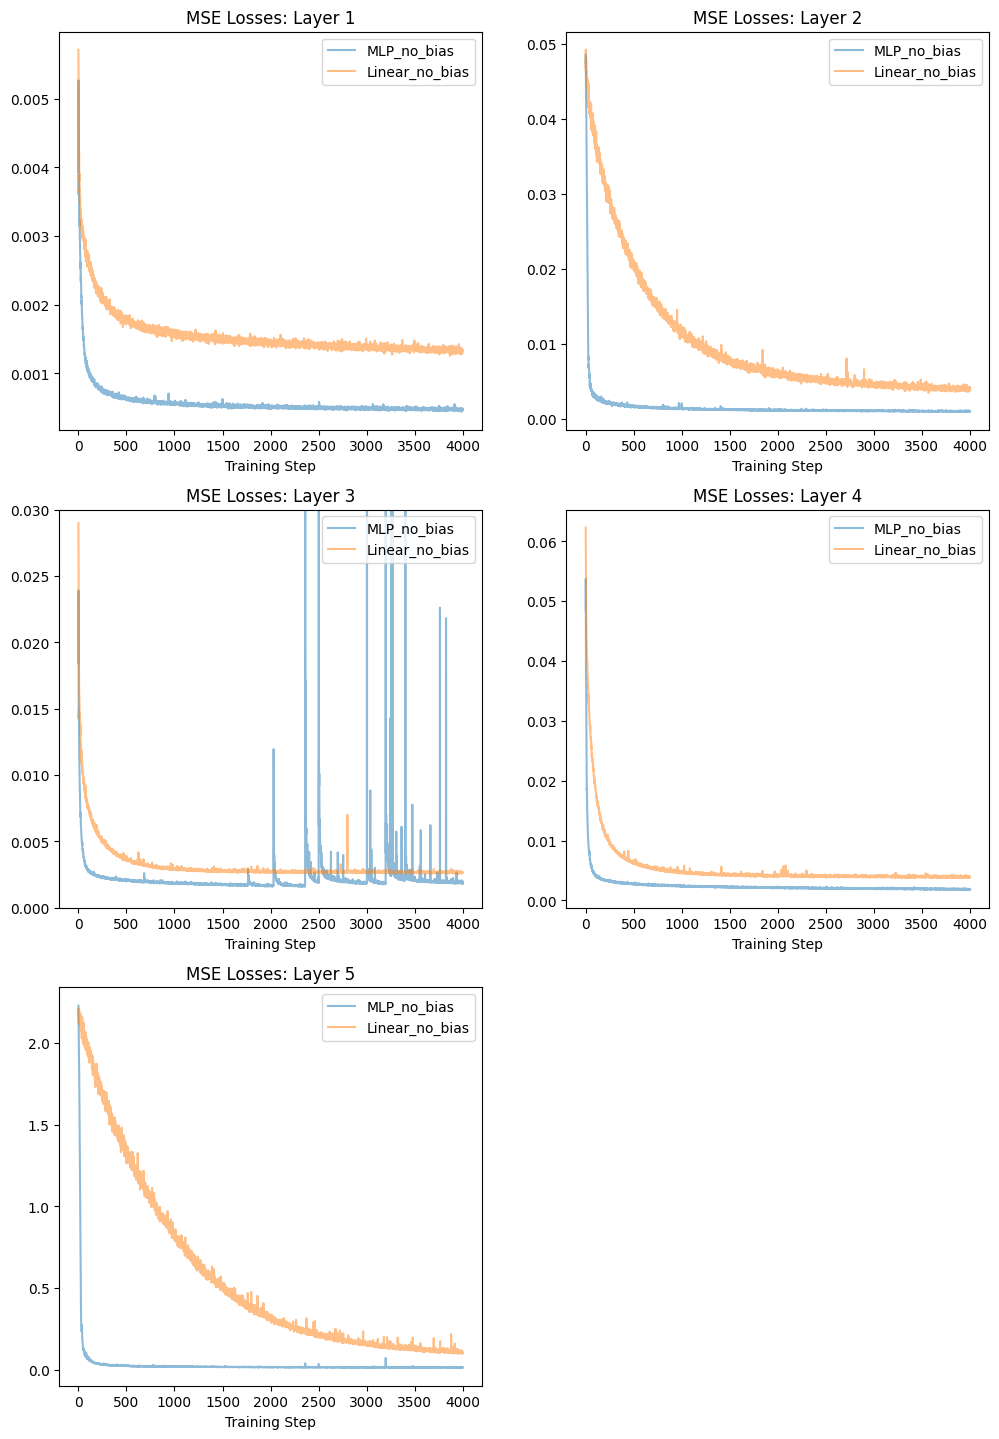

In [16]:
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # make a new plot
    # plt.figure()
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"MSE Losses: Layer {layer+1}")
    # plt.plot(two_mlp_losses[layer])
    # plt.plot(two_nonlinear_losses[layer])
    # plt.plot(mlp_losses[layer])
    plt.plot(mlp_losses_no_bias[layer], alpha=0.5)
    # plt.plot(nonlinear_losses[layer])
    # plt.plot(nonlinear_losses_no_bias[layer])
    # plt.plot(linear_losses[layer])
    plt.plot(linear_losses_no_bias[layer], alpha=0.5)
    if(layer ==2):
        # set max y to 0.05
        plt.ylim(0, 0.03)
    # plt.legend(["Two Nonlinear", "MLP", "MLP_no_bias", "Nonlinear", "Nonlinear_no_bias", "Linear", "Linear_no_bias"])
    # plt.legend(["Two Nonlinear", "MLP", "Nonlinear", "Linear"])
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    # plt.ylabel("MSE Loss")
    # set yaxis to log
    # plt.yscale('log')
plt.show()

## Plot Feature-level losses

In [14]:
# Get the losses for each feature
mse = nn.MSELoss(reduction="none")
l1_alpha = 1e-3
batch_size = 32

# with dataset.formatted_as("pt"):
#     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
max_batches = 100
num_alive_features = alive_features_ind.sum(dim=1).cpu()
loss_diff = [torch.zeros(num_alive_feat) for num_alive_feat in num_alive_features]
# loss_diff = torch.zeros((len(cache_names)//2, 1024))
norms = np.zeros(len(cache_names)//2)
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):

            input_cache_name = cache_names[cache_name_ind * 2]
            output_cache_name = cache_names[cache_name_ind * 2 + 1]
            input_autoencoder = autoencoders[cache_name_ind * 2]
            output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output

            if isinstance(input_activations, tuple):
                input_activations = input_activations[0]
            if isinstance(output_activations, tuple):
                output_activations = output_activations[0]

            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

            if(i == 0):
                # Print the norms of both input & output
                print(f"Layer: {cache_name_ind+1}")
                print(f"Input Norms: {input_internal_activations.norm(dim=1).mean():.2f}")
                print(f"Output Norms: {output_internal_activations.norm(dim=1).mean():.2f}")
                norms[cache_name_ind] = output_internal_activations.norm(dim=1).mean().cpu()
                
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)

            # if(i == 0):
                # Also check dead features
                # print(f"Input Dead Features: {(input_internal_activations.count_nonzero(dim=0) == 0).sum()}")
                # print(f"Output Dead Features: {(output_internal_activations.count_nonzero(dim=0) == 0).sum()}")

            # Run features through mlp & linear
            x_hat_mlp = mlp_weights_no_bias[cache_name_ind](input_internal_activations)
            x_hat_linear = linear_weights_no_bias[cache_name_ind](input_internal_activations)
            
            # Get ind of alive features
            current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
            index_x_hat_mlp = x_hat_mlp.index_select(dim=1, index=current_alive_features_ind)
            index_x_hat_linear = x_hat_linear.index_select(dim=1, index=current_alive_features_ind)
            index_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)

            # We want to compare the MLP loss & linear loss
            # for every feature, so we mean the batch & pos, but not the feature
            mlp_loss = mse(index_x_hat_mlp, index_output_internal_activations).mean(dim=0).cpu()
            linear_loss = mse(index_x_hat_linear, index_output_internal_activations).mean(dim=0).cpu()

            # instead of mse, do cosine sim
            # mlp_loss = torch.cosine_similarity(x_hat_mlp, output_internal_activations, dim=1).cpu()
            # linear_loss = torch.cosine_similarity(x_hat_linear, output_internal_activations, dim=1).cpu()
            loss_diff[cache_name_ind] += linear_loss - mlp_loss
        if(i >= max_batches):
            break
loss_diff =  [loss_d / max_batches for loss_d in loss_diff]

  0%|          | 1/10963 [00:00<1:37:11,  1.88it/s]

Layer: 1
Input Norms: 7.20
Output Norms: 4.26
Layer: 2
Input Norms: 9.14
Output Norms: 6.81
Layer: 3
Input Norms: 13.24
Output Norms: 9.47
Layer: 4
Input Norms: 15.14
Output Norms: 13.14
Layer: 5
Input Norms: 16.36
Output Norms: 54.53


  1%|          | 100/10963 [00:11<20:03,  9.02it/s]


layer 0: 0.788
layer 1: 0.959
layer 2: 0.978
layer 3: 0.980
layer 4: 0.989


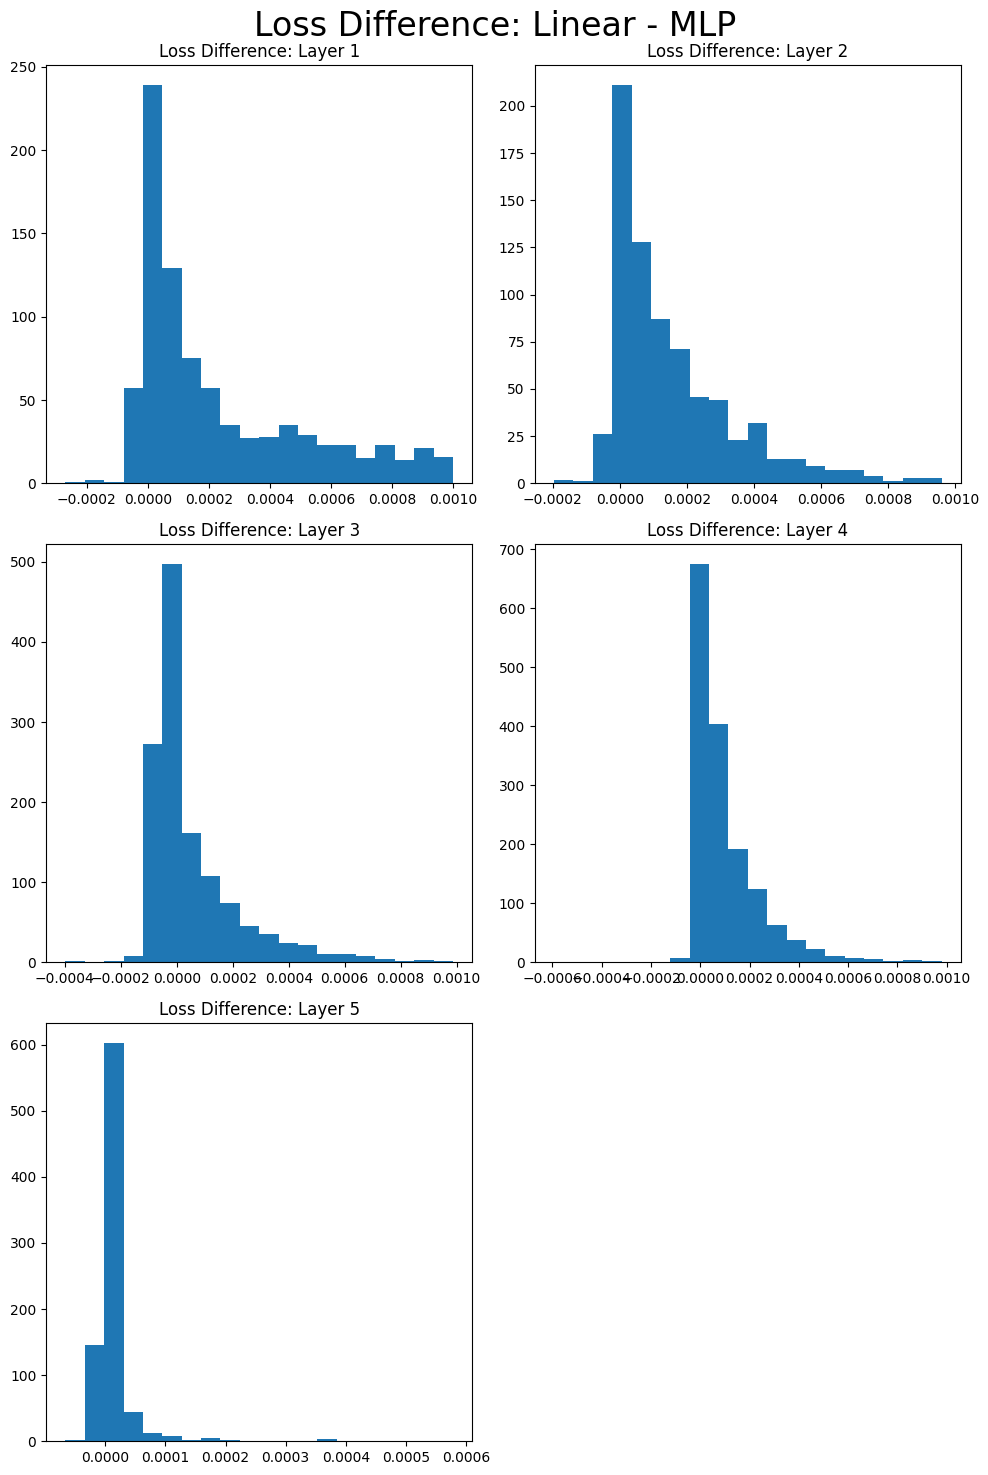

In [15]:
import matplotlib.pyplot as plt
normalization_per_layer = (norms/norms.min())**2

outlier_thresh =  10.0
num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.001
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    # filtered = loss_d[~is_outlier(loss_d, outlier_thresh)]
    filtered = loss_d[loss_d < threshold]
    percent_below_threshold = loss_d[loss_d < threshold].shape[0] / loss_d.shape[0]
    print(f"layer {layer}: {percent_below_threshold:.3f}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.hist(filtered, bins = 20)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
plt.suptitle("Loss Difference: Linear - MLP", fontsize=24)
plt.tight_layout()
plt.show()

layer 0: torch.return_types.topk(
values=tensor([0.1401, 0.0860, 0.0159, 0.0150, 0.0125]),
indices=tensor([ 870,  671,  502,  787, 1035]))
layer 1: torch.return_types.topk(
values=tensor([0.3370, 0.3324, 0.2910, 0.1682, 0.1069]),
indices=tensor([706, 303, 594, 392,  70]))
layer 2: torch.return_types.topk(
values=tensor([0.0456, 0.0163, 0.0122, 0.0101, 0.0069]),
indices=tensor([ 643, 1082,  470, 1193,  396]))
layer 3: torch.return_types.topk(
values=tensor([0.0529, 0.0134, 0.0106, 0.0106, 0.0099]),
indices=tensor([  35, 1492,   37, 1390, 1243]))
layer 4: torch.return_types.topk(
values=tensor([1.5555, 0.0116, 0.0052, 0.0040, 0.0038]),
indices=tensor([752, 348,  63, 684, 228]))


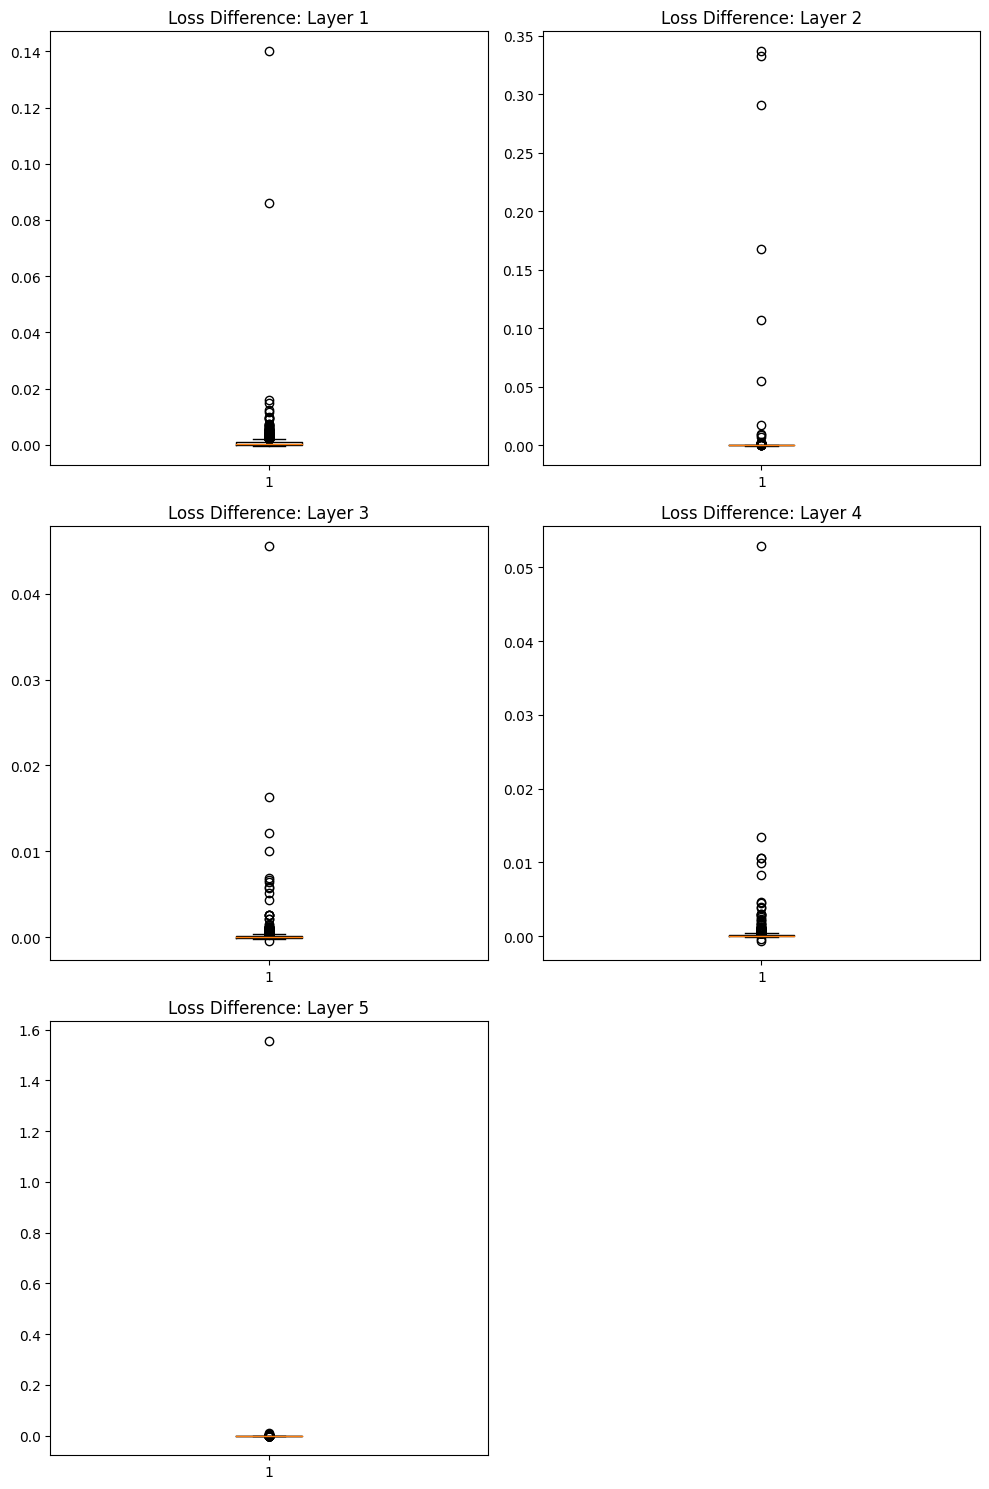

In [17]:
import matplotlib.pyplot as plt

num_layers = len(loss_diff)
num_columns = 2  # Adjust this for the desired number of plots per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed
threshold = 0.01
for layer in range(num_layers):
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")
    loss_d = loss_diff[layer].cpu().numpy()/ normalization_per_layer[layer]
    # print the topk ind of features
    topk = 5
    print(f"layer {layer}: {torch.tensor(loss_d).topk(topk)}")
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"Loss Difference: Layer {layer + 1}")
    plt.boxplot(loss_d)
    # Uncomment the next line if you also want to print the percentage above threshold
    # print(f"Percentage of features above {threshold} for layer {layer}: {(loss_diff[layer] > threshold).sum() / len(loss_diff[layer])}")

plt.tight_layout()
plt.show()

torch.return_types.topk(
values=tensor([1.3722e+01, 4.6175e-02, 1.7231e-02, 1.0577e-02, 2.8266e-03]),
indices=tensor([758, 136, 211, 481, 349]))

# Find linearly computed features & MLP ones

In [20]:
linear_features = []
mlp_features = []
threshold = 0.001
for layer in range(num_layers):
    loss_d = loss_diff[layer].cpu().numpy() / normalization_per_layer[layer]
    linear_ind = loss_d <= threshold
    linear_features.append(linear_ind)
    
    mlp_ind = loss_d > threshold
    mlp_features.append(mlp_ind)
# Save the features to file
import pickle
with open("linear_features.pkl", "wb") as f:
    pickle.dump(linear_features, f)
with open("mlp_features.pkl", "wb") as f:
    pickle.dump(mlp_features, f)
# Also save alive features
with open("alive_features.pkl", "wb") as f:
    pickle.dump(alive_features_ind, f)

In [6]:
# Load in the features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)

## Pareto frontier of l1 alpha for linear layer (no bias), then MLP (no bias)

In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 8
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [23]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas, feature_ind, max_batches = 500, hidden_l1_loss=False):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                indexed_x_hat = x_hat
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=alive_and_selected_features)
                
                # Divide MSE_loss by normalization factor
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                # check if sparse_weight.linear2 exists
                if hasattr(sparse_weight, "linear2"):
                    l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                    l1_loss /= 2
                unweighted_loss = mse_loss + l1_loss
                loss = mse_loss + l1_alpha * l1_loss
                if(hidden_l1_loss):
                    hidden_loss = torch.norm(sparse_weight.linear.weight, dim=0, p=1).mean()
                    unweighted_loss += hidden_loss
                    loss += l1_alpha * hidden_loss

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > max_batches:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1


In [ ]:

# l1_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 100]
l1_alphas = [1e-7, 1e-5, 1e-3, .1, 10, 100]
# l1_alphas = [1e-4, 0.01, .1, 1, 10]

mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features)

In [25]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

l1_alpha_num = len(l1_alphas)
mlp_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
linear_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        mlp_mse_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        mlp_l1_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1[layer][l1_alpha_ind][-1]
        linear_mse_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        linear_l1_losses_last[layer, l1_alpha_ind] = linear_losses_no_bias_l1[layer][l1_alpha_ind][-1]


plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_l1_losses_last[layer] 
    mlp_mse_loss = mlp_mse_losses_last[layer] 
    linear_l1_loss = linear_l1_losses_last[layer] 
    linear_mse_loss = linear_mse_losses_last[layer] 
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.plot(linear_l1_loss, linear_mse_loss, 'o', label="Linear_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    # plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

IndexError: list index out of range

# Optimize one sparse model for a long time

In [24]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
l1_alpha = 1
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [25]:
l1_alphas = [8e-4]
max_batches = 3000
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features, max_batches=max_batches)
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, l1_alphas, linear_features, max_batches=max_batches)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.011997264809906483 | L1 Loss: 27.708736419677734
Layers: 1 | l1 alpha MSE Loss: 0.5747371315956116 | L1 Loss: 27.671335220336914
Layers: 2 | l1 alpha MSE Loss: 0.11847595870494843 | L1 Loss: 27.747163772583008
Layers: 3 | l1 alpha MSE Loss: 0.19381678104400635 | L1 Loss: 27.711936950683594


  0%|          | 1/10963 [00:00<2:23:53,  1.27it/s]

Layers: 4 | l1 alpha MSE Loss: 2.013000249862671 | L1 Loss: 27.783546447753906


  1%|          | 100/10963 [00:34<1:00:10,  3.01it/s]

Layers: 0 | l1 alpha MSE Loss: 0.006543758325278759 | L1 Loss: 2.6212146282196045
Layers: 1 | l1 alpha MSE Loss: 0.03325902670621872 | L1 Loss: 18.156299591064453
Layers: 2 | l1 alpha MSE Loss: 0.014121967367827892 | L1 Loss: 10.05138111114502
Layers: 3 | l1 alpha MSE Loss: 0.010056840255856514 | L1 Loss: 9.681305885314941


  1%|          | 101/10963 [00:35<59:51,  3.02it/s]  

Layers: 4 | l1 alpha MSE Loss: 0.052065830677747726 | L1 Loss: 21.872802734375


  2%|▏         | 200/10963 [01:04<49:36,  3.62it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.004965449217706919 | L1 Loss: 2.4414260387420654
Layers: 1 | l1 alpha MSE Loss: 0.03318862244486809 | L1 Loss: 15.588093757629395
Layers: 2 | l1 alpha MSE Loss: 0.01217240747064352 | L1 Loss: 7.743060111999512
Layers: 3 | l1 alpha MSE Loss: 0.0082315094769001 | L1 Loss: 7.678687572479248
Layers: 4 | l1 alpha MSE Loss: 0.03180810809135437 | L1 Loss: 19.19195556640625


  3%|▎         | 300/10963 [01:36<55:43,  3.19it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.004453396890312433 | L1 Loss: 2.423583507537842
Layers: 1 | l1 alpha MSE Loss: 0.037043824791908264 | L1 Loss: 14.405471801757812
Layers: 2 | l1 alpha MSE Loss: 0.00998383853584528 | L1 Loss: 6.562058448791504
Layers: 3 | l1 alpha MSE Loss: 0.009288201108574867 | L1 Loss: 6.655252456665039


  3%|▎         | 301/10963 [01:37<55:00,  3.23it/s]

Layers: 4 | l1 alpha MSE Loss: 0.03074111044406891 | L1 Loss: 17.207944869995117


  4%|▎         | 401/10963 [02:08<47:03,  3.74it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.003506834851577878 | L1 Loss: 2.439516544342041
Layers: 1 | l1 alpha MSE Loss: 0.04922456666827202 | L1 Loss: 13.669270515441895
Layers: 2 | l1 alpha MSE Loss: 0.009803642518818378 | L1 Loss: 5.8143768310546875
Layers: 3 | l1 alpha MSE Loss: 0.00970937218517065 | L1 Loss: 6.022095680236816
Layers: 4 | l1 alpha MSE Loss: 0.03313453495502472 | L1 Loss: 15.840743064880371


  5%|▍         | 501/10963 [02:38<47:55,  3.64it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004710300825536251 | L1 Loss: 2.340985059738159
Layers: 1 | l1 alpha MSE Loss: 0.024295954033732414 | L1 Loss: 13.180914878845215
Layers: 2 | l1 alpha MSE Loss: 0.009019465185701847 | L1 Loss: 5.300899505615234
Layers: 3 | l1 alpha MSE Loss: 0.0068712374195456505 | L1 Loss: 5.725592613220215
Layers: 4 | l1 alpha MSE Loss: 0.021104134619235992 | L1 Loss: 14.93978500366211


  5%|▌         | 601/10963 [03:05<47:32,  3.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0032249654177576303 | L1 Loss: 2.2704806327819824
Layers: 1 | l1 alpha MSE Loss: 0.020526044070720673 | L1 Loss: 12.788614273071289
Layers: 2 | l1 alpha MSE Loss: 0.00972903985530138 | L1 Loss: 4.951994895935059
Layers: 3 | l1 alpha MSE Loss: 0.00829476397484541 | L1 Loss: 5.044472694396973
Layers: 4 | l1 alpha MSE Loss: 0.02659621275961399 | L1 Loss: 14.145973205566406


  6%|▋         | 701/10963 [03:33<47:58,  3.56it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0026154571678489447 | L1 Loss: 2.2436130046844482
Layers: 1 | l1 alpha MSE Loss: 0.033241286873817444 | L1 Loss: 12.394393920898438
Layers: 2 | l1 alpha MSE Loss: 0.01250381488353014 | L1 Loss: 4.590096950531006
Layers: 3 | l1 alpha MSE Loss: 0.007746475283056498 | L1 Loss: 4.715106010437012
Layers: 4 | l1 alpha MSE Loss: 0.024908820167183876 | L1 Loss: 13.720962524414062


  7%|▋         | 801/10963 [04:01<44:30,  3.80it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004179676063358784 | L1 Loss: 2.1956095695495605
Layers: 1 | l1 alpha MSE Loss: 0.017110655084252357 | L1 Loss: 12.069793701171875
Layers: 2 | l1 alpha MSE Loss: 0.008275645785033703 | L1 Loss: 4.3787336349487305
Layers: 3 | l1 alpha MSE Loss: 0.005701515357941389 | L1 Loss: 4.638045310974121
Layers: 4 | l1 alpha MSE Loss: 0.019557146355509758 | L1 Loss: 13.155923843383789


  8%|▊         | 901/10963 [04:29<46:13,  3.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0036076935939490795 | L1 Loss: 2.1716866493225098
Layers: 1 | l1 alpha MSE Loss: 0.034545816481113434 | L1 Loss: 11.456260681152344
Layers: 2 | l1 alpha MSE Loss: 0.009460685774683952 | L1 Loss: 4.188669204711914
Layers: 3 | l1 alpha MSE Loss: 0.006531510967761278 | L1 Loss: 4.47378396987915
Layers: 4 | l1 alpha MSE Loss: 0.020331133157014847 | L1 Loss: 12.529090881347656


  9%|▉         | 1001/10963 [04:57<44:05,  3.77it/s] 

Layers: 0 | l1 alpha MSE Loss: 0.004125060513615608 | L1 Loss: 2.1441731452941895
Layers: 1 | l1 alpha MSE Loss: 0.01987098902463913 | L1 Loss: 11.422016143798828
Layers: 2 | l1 alpha MSE Loss: 0.008174010552465916 | L1 Loss: 3.97446870803833
Layers: 3 | l1 alpha MSE Loss: 0.008472850546240807 | L1 Loss: 4.114040374755859
Layers: 4 | l1 alpha MSE Loss: 0.023579062893986702 | L1 Loss: 12.080381393432617


 10%|█         | 1100/10963 [05:24<44:55,  3.66it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0037982494104653597 | L1 Loss: 2.1431336402893066
Layers: 1 | l1 alpha MSE Loss: 0.02495715208351612 | L1 Loss: 11.254396438598633
Layers: 2 | l1 alpha MSE Loss: 0.007446044124662876 | L1 Loss: 3.923394203186035
Layers: 3 | l1 alpha MSE Loss: 0.008737298659980297 | L1 Loss: 3.9532864093780518
Layers: 4 | l1 alpha MSE Loss: 0.026389380916953087 | L1 Loss: 11.639839172363281


 11%|█         | 1200/10963 [05:53<45:13,  3.60it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0033680114429444075 | L1 Loss: 2.1051275730133057
Layers: 1 | l1 alpha MSE Loss: 0.015157194808125496 | L1 Loss: 10.756807327270508
Layers: 2 | l1 alpha MSE Loss: 0.008116432465612888 | L1 Loss: 3.792435646057129
Layers: 3 | l1 alpha MSE Loss: 0.006014630664139986 | L1 Loss: 3.8001060485839844


 11%|█         | 1201/10963 [05:53<46:20,  3.51it/s]

Layers: 4 | l1 alpha MSE Loss: 0.018755938857793808 | L1 Loss: 11.300838470458984


 12%|█▏        | 1300/10963 [06:23<45:42,  3.52it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0031500253826379776 | L1 Loss: 2.068551540374756
Layers: 1 | l1 alpha MSE Loss: 0.015510640107095242 | L1 Loss: 10.651512145996094
Layers: 2 | l1 alpha MSE Loss: 0.008872102946043015 | L1 Loss: 3.682588577270508
Layers: 3 | l1 alpha MSE Loss: 0.005110492929816246 | L1 Loss: 3.621786117553711


 12%|█▏        | 1301/10963 [06:23<46:31,  3.46it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01667971909046173 | L1 Loss: 10.751642227172852


 13%|█▎        | 1401/10963 [06:53<41:39,  3.83it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0029389874543994665 | L1 Loss: 2.0472464561462402
Layers: 1 | l1 alpha MSE Loss: 0.023434216156601906 | L1 Loss: 10.532968521118164
Layers: 2 | l1 alpha MSE Loss: 0.0086544593796134 | L1 Loss: 3.6183440685272217
Layers: 3 | l1 alpha MSE Loss: 0.0065701305866241455 | L1 Loss: 3.5311107635498047
Layers: 4 | l1 alpha MSE Loss: 0.020447708666324615 | L1 Loss: 10.506401062011719


 14%|█▎        | 1500/10963 [07:20<43:40,  3.61it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0030344664119184017 | L1 Loss: 2.053062677383423
Layers: 1 | l1 alpha MSE Loss: 0.014441581442952156 | L1 Loss: 10.277868270874023
Layers: 2 | l1 alpha MSE Loss: 0.008629053831100464 | L1 Loss: 3.514103412628174
Layers: 3 | l1 alpha MSE Loss: 0.006516812834888697 | L1 Loss: 3.4566383361816406
Layers: 4 | l1 alpha MSE Loss: 0.020791837945580482 | L1 Loss: 10.27286148071289


 15%|█▍        | 1601/10963 [07:48<43:08,  3.62it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0030382471159100533 | L1 Loss: 1.9961460828781128
Layers: 1 | l1 alpha MSE Loss: 0.021718250587582588 | L1 Loss: 10.019956588745117
Layers: 2 | l1 alpha MSE Loss: 0.008827920071780682 | L1 Loss: 3.457313060760498
Layers: 3 | l1 alpha MSE Loss: 0.005976531654596329 | L1 Loss: 3.390794515609741
Layers: 4 | l1 alpha MSE Loss: 0.0179373100399971 | L1 Loss: 9.866628646850586


 16%|█▌        | 1700/10963 [08:21<57:11,  2.70it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0030446224845945835 | L1 Loss: 1.9719221591949463
Layers: 1 | l1 alpha MSE Loss: 0.018802350386977196 | L1 Loss: 9.879976272583008
Layers: 2 | l1 alpha MSE Loss: 0.008115594275295734 | L1 Loss: 3.383967399597168


 16%|█▌        | 1701/10963 [08:21<1:00:36,  2.55it/s]

Layers: 3 | l1 alpha MSE Loss: 0.005941202864050865 | L1 Loss: 3.251965045928955
Layers: 4 | l1 alpha MSE Loss: 0.02198401652276516 | L1 Loss: 9.59384536743164


 16%|█▋        | 1800/10963 [08:51<43:30,  3.51it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0029702791944146156 | L1 Loss: 1.955492615699768
Layers: 1 | l1 alpha MSE Loss: 0.01723286136984825 | L1 Loss: 9.782759666442871
Layers: 2 | l1 alpha MSE Loss: 0.009401489049196243 | L1 Loss: 3.35237717628479
Layers: 3 | l1 alpha MSE Loss: 0.01038992591202259 | L1 Loss: 3.157665729522705


 16%|█▋        | 1801/10963 [08:52<43:59,  3.47it/s]

Layers: 4 | l1 alpha MSE Loss: 0.16602249443531036 | L1 Loss: 9.057584762573242


 17%|█▋        | 1900/10963 [09:20<42:28,  3.56it/s]

Layers: 0 | l1 alpha MSE Loss: 0.003453602781519294 | L1 Loss: 1.952643632888794
Layers: 1 | l1 alpha MSE Loss: 0.017223786562681198 | L1 Loss: 9.703109741210938
Layers: 2 | l1 alpha MSE Loss: 0.010124141350388527 | L1 Loss: 3.2873473167419434
Layers: 3 | l1 alpha MSE Loss: 0.00701091717928648 | L1 Loss: 3.1246700286865234


 17%|█▋        | 1901/10963 [09:21<42:40,  3.54it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01981796883046627 | L1 Loss: 9.213401794433594


 18%|█▊        | 2000/10963 [09:51<53:59,  2.77it/s]

Layers: 0 | l1 alpha MSE Loss: 0.003409289987757802 | L1 Loss: 1.917984127998352
Layers: 1 | l1 alpha MSE Loss: 0.020567506551742554 | L1 Loss: 9.408909797668457
Layers: 2 | l1 alpha MSE Loss: 0.00751033890992403 | L1 Loss: 3.263828992843628
Layers: 3 | l1 alpha MSE Loss: 0.004943861626088619 | L1 Loss: 3.0382399559020996


 18%|█▊        | 2001/10963 [09:51<52:45,  2.83it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01572577841579914 | L1 Loss: 8.821881294250488


 19%|█▉        | 2100/10963 [10:24<47:32,  3.11it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0025564832612872124 | L1 Loss: 1.9136935472488403
Layers: 1 | l1 alpha MSE Loss: 0.014234917238354683 | L1 Loss: 9.247772216796875
Layers: 2 | l1 alpha MSE Loss: 0.007997858338057995 | L1 Loss: 3.21086049079895
Layers: 3 | l1 alpha MSE Loss: 0.005773433018475771 | L1 Loss: 2.9923317432403564


 19%|█▉        | 2101/10963 [10:25<50:00,  2.95it/s]

Layers: 4 | l1 alpha MSE Loss: 0.014211664907634258 | L1 Loss: 8.354820251464844


 20%|██        | 2201/10963 [10:56<39:52,  3.66it/s]

Layers: 0 | l1 alpha MSE Loss: 0.002553911181166768 | L1 Loss: 1.9013450145721436
Layers: 1 | l1 alpha MSE Loss: 0.01614324375987053 | L1 Loss: 9.222941398620605
Layers: 2 | l1 alpha MSE Loss: 0.008755923248827457 | L1 Loss: 3.190462112426758
Layers: 3 | l1 alpha MSE Loss: 0.006038464140146971 | L1 Loss: 2.9547781944274902
Layers: 4 | l1 alpha MSE Loss: 0.023926351219415665 | L1 Loss: 8.129108428955078


 21%|██        | 2300/10963 [11:26<54:09,  2.67it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0028415818233042955 | L1 Loss: 1.8991724252700806
Layers: 1 | l1 alpha MSE Loss: 0.015433109365403652 | L1 Loss: 9.080117225646973
Layers: 2 | l1 alpha MSE Loss: 0.0087721087038517 | L1 Loss: 3.1444573402404785
Layers: 3 | l1 alpha MSE Loss: 0.0068852463737130165 | L1 Loss: 2.9575726985931396


 21%|██        | 2301/10963 [11:27<53:16,  2.71it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01925520971417427 | L1 Loss: 7.879019737243652


 22%|██▏       | 2400/10963 [12:00<40:56,  3.49it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0025456976145505905 | L1 Loss: 1.8712706565856934
Layers: 1 | l1 alpha MSE Loss: 0.01807340234518051 | L1 Loss: 9.41128158569336
Layers: 2 | l1 alpha MSE Loss: 0.009267015382647514 | L1 Loss: 3.1230340003967285
Layers: 3 | l1 alpha MSE Loss: 0.005930713377892971 | L1 Loss: 2.8947458267211914
Layers: 4 | l1 alpha MSE Loss: 0.017881037667393684 | L1 Loss: 7.799265384674072


 23%|██▎       | 2500/10963 [12:35<58:53,  2.40it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0031395312398672104 | L1 Loss: 1.8483437299728394
Layers: 1 | l1 alpha MSE Loss: 0.028864989057183266 | L1 Loss: 8.904754638671875
Layers: 2 | l1 alpha MSE Loss: 0.008336415514349937 | L1 Loss: 3.0695323944091797


 23%|██▎       | 2501/10963 [12:36<56:23,  2.50it/s]

Layers: 3 | l1 alpha MSE Loss: 0.006018451880663633 | L1 Loss: 2.8236289024353027
Layers: 4 | l1 alpha MSE Loss: 0.01749221608042717 | L1 Loss: 7.736228942871094


 24%|██▎       | 2600/10963 [13:06<45:39,  3.05it/s]

Layers: 0 | l1 alpha MSE Loss: 0.002734928159043193 | L1 Loss: 1.8485419750213623
Layers: 1 | l1 alpha MSE Loss: 0.010493777692317963 | L1 Loss: 8.88906192779541
Layers: 2 | l1 alpha MSE Loss: 0.006272002588957548 | L1 Loss: 3.07275652885437
Layers: 3 | l1 alpha MSE Loss: 0.005839491728693247 | L1 Loss: 2.8091816902160645


 24%|██▎       | 2601/10963 [13:06<44:33,  3.13it/s]

Layers: 4 | l1 alpha MSE Loss: 0.025239910930395126 | L1 Loss: 7.654260635375977


 25%|██▍       | 2700/10963 [13:38<42:06,  3.27it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0032106933649629354 | L1 Loss: 1.8305643796920776
Layers: 1 | l1 alpha MSE Loss: 0.022368350997567177 | L1 Loss: 8.667616844177246
Layers: 2 | l1 alpha MSE Loss: 0.007644842844456434 | L1 Loss: 3.0753700733184814
Layers: 3 | l1 alpha MSE Loss: 0.0066329785622656345 | L1 Loss: 2.9979538917541504
Layers: 4 | l1 alpha MSE Loss: 0.024659957736730576 | L1 Loss: 8.030257225036621


 26%|██▌       | 2801/10963 [14:11<40:49,  3.33it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0029792464338243008 | L1 Loss: 1.8169035911560059
Layers: 1 | l1 alpha MSE Loss: 0.012958443723618984 | L1 Loss: 8.727374076843262
Layers: 2 | l1 alpha MSE Loss: 0.008896112442016602 | L1 Loss: 3.0139575004577637
Layers: 3 | l1 alpha MSE Loss: 0.006938471924513578 | L1 Loss: 2.7907028198242188
Layers: 4 | l1 alpha MSE Loss: 0.022392617538571358 | L1 Loss: 7.644898891448975


 26%|██▋       | 2900/10963 [14:44<43:04,  3.12it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0024525197222828865 | L1 Loss: 1.799096941947937
Layers: 1 | l1 alpha MSE Loss: 0.01229125913232565 | L1 Loss: 8.614860534667969
Layers: 2 | l1 alpha MSE Loss: 0.007464940659701824 | L1 Loss: 2.994967222213745
Layers: 3 | l1 alpha MSE Loss: 0.004755722358822823 | L1 Loss: 2.708261489868164


 26%|██▋       | 2901/10963 [14:44<43:07,  3.12it/s]

Layers: 4 | l1 alpha MSE Loss: 0.01516395527869463 | L1 Loss: 7.985100269317627


 27%|██▋       | 3000/10963 [15:13<39:27,  3.36it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0026877103373408318 | L1 Loss: 1.7923991680145264
Layers: 1 | l1 alpha MSE Loss: 0.01947460137307644 | L1 Loss: 8.512008666992188
Layers: 2 | l1 alpha MSE Loss: 0.008187361061573029 | L1 Loss: 2.9756174087524414
Layers: 3 | l1 alpha MSE Loss: 0.0051034074276685715 | L1 Loss: 2.6802728176116943


 27%|██▋       | 3001/10963 [15:14<39:36,  3.35it/s]

Layers: 4 | l1 alpha MSE Loss: 0.011950594373047352 | L1 Loss: 7.562723636627197


  0%|          | 1/10963 [00:00<26:07,  6.99it/s]

Layers: 0 | l1 alpha MSE Loss: 0.004117520526051521 | L1 Loss: 27.705007553100586
Layers: 1 | l1 alpha MSE Loss: 0.0030679937917739153 | L1 Loss: 27.71497917175293
Layers: 2 | l1 alpha MSE Loss: 0.004209000151604414 | L1 Loss: 27.711936950683594
Layers: 3 | l1 alpha MSE Loss: 0.0032305284403264523 | L1 Loss: 27.70248794555664
Layers: 4 | l1 alpha MSE Loss: 0.00043179793283343315 | L1 Loss: 27.717430114746094


  1%|          | 101/10963 [00:14<28:27,  6.36it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0015022766310721636 | L1 Loss: 0.435218870639801
Layers: 1 | l1 alpha MSE Loss: 0.001615296583622694 | L1 Loss: 0.4758685827255249
Layers: 2 | l1 alpha MSE Loss: 0.0011007316643372178 | L1 Loss: 0.45430490374565125
Layers: 3 | l1 alpha MSE Loss: 0.0007761924644000828 | L1 Loss: 0.42892876267433167
Layers: 4 | l1 alpha MSE Loss: 0.0002622106403578073 | L1 Loss: 0.38565701246261597


  2%|▏         | 201/10963 [00:28<23:47,  7.54it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0016353219980373979 | L1 Loss: 0.44595515727996826
Layers: 1 | l1 alpha MSE Loss: 0.0013719424605369568 | L1 Loss: 0.5037757158279419
Layers: 2 | l1 alpha MSE Loss: 0.0009927296778187156 | L1 Loss: 0.4698234796524048
Layers: 3 | l1 alpha MSE Loss: 0.000668138440232724 | L1 Loss: 0.4329909682273865
Layers: 4 | l1 alpha MSE Loss: 0.00018354589701630175 | L1 Loss: 0.37787333130836487


  3%|▎         | 302/10963 [00:41<20:06,  8.84it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008953106589615345 | L1 Loss: 0.47069528698921204
Layers: 1 | l1 alpha MSE Loss: 0.0012022483861073852 | L1 Loss: 0.5383821129798889
Layers: 2 | l1 alpha MSE Loss: 0.0012966911308467388 | L1 Loss: 0.49410879611968994
Layers: 3 | l1 alpha MSE Loss: 0.0005549812340177596 | L1 Loss: 0.4485175311565399
Layers: 4 | l1 alpha MSE Loss: 0.000555335427634418 | L1 Loss: 0.3839702606201172


  4%|▎         | 401/10963 [00:52<24:05,  7.31it/s]

Layers: 0 | l1 alpha MSE Loss: 0.001038568327203393 | L1 Loss: 0.4883161187171936
Layers: 1 | l1 alpha MSE Loss: 0.0008915807702578604 | L1 Loss: 0.5636751055717468
Layers: 2 | l1 alpha MSE Loss: 0.0008033412741497159 | L1 Loss: 0.5137254595756531
Layers: 3 | l1 alpha MSE Loss: 0.0005974063533358276 | L1 Loss: 0.46008479595184326
Layers: 4 | l1 alpha MSE Loss: 0.0001710330689093098 | L1 Loss: 0.38524430990219116


  5%|▍         | 502/10963 [01:06<21:10,  8.23it/s]

Layers: 0 | l1 alpha MSE Loss: 0.001105255912989378 | L1 Loss: 0.5045921802520752
Layers: 1 | l1 alpha MSE Loss: 0.00087707833154127 | L1 Loss: 0.5843186378479004
Layers: 2 | l1 alpha MSE Loss: 0.0007961844094097614 | L1 Loss: 0.526554524898529
Layers: 3 | l1 alpha MSE Loss: 0.0006265348638407886 | L1 Loss: 0.46607235074043274
Layers: 4 | l1 alpha MSE Loss: 0.0001623571733944118 | L1 Loss: 0.3811313807964325


  5%|▌         | 601/10963 [01:20<27:56,  6.18it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0011235643178224564 | L1 Loss: 0.5212774872779846
Layers: 1 | l1 alpha MSE Loss: 0.0008798989001661539 | L1 Loss: 0.6052431464195251
Layers: 2 | l1 alpha MSE Loss: 0.0007459535845555365 | L1 Loss: 0.5463822484016418
Layers: 3 | l1 alpha MSE Loss: 0.0005697691231034696 | L1 Loss: 0.47688028216362
Layers: 4 | l1 alpha MSE Loss: 0.00013233028585091233 | L1 Loss: 0.3845425248146057


  6%|▋         | 701/10963 [01:33<20:14,  8.45it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0010346441995352507 | L1 Loss: 0.5339117646217346
Layers: 1 | l1 alpha MSE Loss: 0.0008264909847639501 | L1 Loss: 0.6194432377815247
Layers: 2 | l1 alpha MSE Loss: 0.0007940637296997011 | L1 Loss: 0.5564038753509521
Layers: 3 | l1 alpha MSE Loss: 0.0005808576242998242 | L1 Loss: 0.48310139775276184
Layers: 4 | l1 alpha MSE Loss: 0.00015539037121925503 | L1 Loss: 0.38420963287353516


  7%|▋         | 802/10963 [01:44<18:24,  9.20it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0009301190148107708 | L1 Loss: 0.5439990758895874
Layers: 1 | l1 alpha MSE Loss: 0.0007626866572536528 | L1 Loss: 0.6325997710227966
Layers: 2 | l1 alpha MSE Loss: 0.0007917277398519218 | L1 Loss: 0.5656123757362366
Layers: 3 | l1 alpha MSE Loss: 0.0006524953059852123 | L1 Loss: 0.4859912693500519
Layers: 4 | l1 alpha MSE Loss: 0.00019435388094279915 | L1 Loss: 0.38077718019485474


  8%|▊         | 902/10963 [01:56<18:55,  8.86it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0009542303741909564 | L1 Loss: 0.5565939545631409
Layers: 1 | l1 alpha MSE Loss: 0.0007728557102382183 | L1 Loss: 0.6456236243247986
Layers: 2 | l1 alpha MSE Loss: 0.0007329494692385197 | L1 Loss: 0.5792431235313416
Layers: 3 | l1 alpha MSE Loss: 0.0005162224406376481 | L1 Loss: 0.49989795684814453
Layers: 4 | l1 alpha MSE Loss: 0.0001386504591209814 | L1 Loss: 0.3917974829673767


  9%|▉         | 1002/10963 [02:08<19:13,  8.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008248962694779038 | L1 Loss: 0.5663172006607056
Layers: 1 | l1 alpha MSE Loss: 0.0005892611225135624 | L1 Loss: 0.6572356820106506
Layers: 2 | l1 alpha MSE Loss: 0.0006323590059764683 | L1 Loss: 0.5858765244483948
Layers: 3 | l1 alpha MSE Loss: 0.0004608863382600248 | L1 Loss: 0.4992729723453522
Layers: 4 | l1 alpha MSE Loss: 0.0001376772706862539 | L1 Loss: 0.38474878668785095


 10%|█         | 1101/10963 [02:20<20:43,  7.93it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008897615480236709 | L1 Loss: 0.5710755586624146
Layers: 1 | l1 alpha MSE Loss: 0.0006804275908507407 | L1 Loss: 0.6649490594863892
Layers: 2 | l1 alpha MSE Loss: 0.0006790508632548153 | L1 Loss: 0.5935696959495544
Layers: 3 | l1 alpha MSE Loss: 0.0005620346637442708 | L1 Loss: 0.5056537985801697
Layers: 4 | l1 alpha MSE Loss: 0.00018257628835272044 | L1 Loss: 0.38466399908065796


 11%|█         | 1202/10963 [02:33<18:21,  8.86it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006686098058708012 | L1 Loss: 0.5790393352508545
Layers: 1 | l1 alpha MSE Loss: 0.0005997618427500129 | L1 Loss: 0.6729688048362732
Layers: 2 | l1 alpha MSE Loss: 0.0006061459425836802 | L1 Loss: 0.5982502102851868
Layers: 3 | l1 alpha MSE Loss: 0.0004945914843119681 | L1 Loss: 0.5073343515396118
Layers: 4 | l1 alpha MSE Loss: 0.0001496852928539738 | L1 Loss: 0.3864869475364685


 12%|█▏        | 1302/10963 [02:45<18:32,  8.69it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008580302237533033 | L1 Loss: 0.5888240933418274
Layers: 1 | l1 alpha MSE Loss: 0.0008879225351847708 | L1 Loss: 0.6820475459098816
Layers: 2 | l1 alpha MSE Loss: 0.0009007326443679631 | L1 Loss: 0.6088898777961731
Layers: 3 | l1 alpha MSE Loss: 0.0005417332868091762 | L1 Loss: 0.5153619647026062
Layers: 4 | l1 alpha MSE Loss: 0.00015451438957825303 | L1 Loss: 0.38518229126930237


 13%|█▎        | 1401/10963 [02:58<24:08,  6.60it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008726338273845613 | L1 Loss: 0.5903106331825256
Layers: 1 | l1 alpha MSE Loss: 0.0006950095994397998 | L1 Loss: 0.687915563583374
Layers: 2 | l1 alpha MSE Loss: 0.0006337111699394882 | L1 Loss: 0.6107804179191589
Layers: 3 | l1 alpha MSE Loss: 0.0004890767741017044 | L1 Loss: 0.5170732736587524
Layers: 4 | l1 alpha MSE Loss: 0.00014519535761792213 | L1 Loss: 0.38330698013305664


 14%|█▎        | 1501/10963 [03:11<19:02,  8.28it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006715176859870553 | L1 Loss: 0.5955257415771484
Layers: 1 | l1 alpha MSE Loss: 0.0005457301158457994 | L1 Loss: 0.6949174404144287
Layers: 2 | l1 alpha MSE Loss: 0.0005889617023058236 | L1 Loss: 0.6185757517814636
Layers: 3 | l1 alpha MSE Loss: 0.0004336363053880632 | L1 Loss: 0.5258643627166748
Layers: 4 | l1 alpha MSE Loss: 0.00010997824574587867 | L1 Loss: 0.3906744122505188


 15%|█▍        | 1601/10963 [03:25<18:15,  8.54it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007224578293971717 | L1 Loss: 0.6000673174858093
Layers: 1 | l1 alpha MSE Loss: 0.0005446893046610057 | L1 Loss: 0.6967837810516357
Layers: 2 | l1 alpha MSE Loss: 0.0005558783886954188 | L1 Loss: 0.6170586347579956
Layers: 3 | l1 alpha MSE Loss: 0.000430047424742952 | L1 Loss: 0.526285707950592
Layers: 4 | l1 alpha MSE Loss: 0.0001264340680791065 | L1 Loss: 0.3894815146923065


 16%|█▌        | 1702/10963 [03:37<17:35,  8.77it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007481092470698059 | L1 Loss: 0.6013613939285278
Layers: 1 | l1 alpha MSE Loss: 0.0005836213240399957 | L1 Loss: 0.7014173865318298
Layers: 2 | l1 alpha MSE Loss: 0.000591607706155628 | L1 Loss: 0.6173350214958191
Layers: 3 | l1 alpha MSE Loss: 0.0005027396255172789 | L1 Loss: 0.5203354954719543
Layers: 4 | l1 alpha MSE Loss: 0.0001796315045794472 | L1 Loss: 0.37971773743629456


 16%|█▋        | 1802/10963 [03:48<17:28,  8.74it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008775950409471989 | L1 Loss: 0.6067612171173096
Layers: 1 | l1 alpha MSE Loss: 0.0006848284392617643 | L1 Loss: 0.7042863965034485
Layers: 2 | l1 alpha MSE Loss: 0.0006309429300017655 | L1 Loss: 0.6226364970207214
Layers: 3 | l1 alpha MSE Loss: 0.0005038611707277596 | L1 Loss: 0.5326026678085327
Layers: 4 | l1 alpha MSE Loss: 0.00016023094940464944 | L1 Loss: 0.3918316662311554


 17%|█▋        | 1901/10963 [04:00<20:56,  7.21it/s]

Layers: 0 | l1 alpha MSE Loss: 0.000786007265560329 | L1 Loss: 0.6068487167358398
Layers: 1 | l1 alpha MSE Loss: 0.0005530953058041632 | L1 Loss: 0.7076497077941895
Layers: 2 | l1 alpha MSE Loss: 0.000651825568638742 | L1 Loss: 0.6251705884933472
Layers: 3 | l1 alpha MSE Loss: 0.000499975576531142 | L1 Loss: 0.5304694175720215
Layers: 4 | l1 alpha MSE Loss: 0.00016272846551146358 | L1 Loss: 0.38693779706954956


 18%|█▊        | 2001/10963 [04:12<17:23,  8.59it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007559909136034548 | L1 Loss: 0.6079404354095459
Layers: 1 | l1 alpha MSE Loss: 0.0005932210478931665 | L1 Loss: 0.7083173394203186
Layers: 2 | l1 alpha MSE Loss: 0.000581720843911171 | L1 Loss: 0.6246398687362671
Layers: 3 | l1 alpha MSE Loss: 0.0004448043182492256 | L1 Loss: 0.5285733342170715
Layers: 4 | l1 alpha MSE Loss: 0.00013328195200301707 | L1 Loss: 0.38186565041542053


 19%|█▉        | 2102/10963 [04:24<16:58,  8.70it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007668999605812132 | L1 Loss: 0.6115927696228027
Layers: 1 | l1 alpha MSE Loss: 0.0006096906145103276 | L1 Loss: 0.7120087146759033
Layers: 2 | l1 alpha MSE Loss: 0.0006315835635177791 | L1 Loss: 0.6276446580886841
Layers: 3 | l1 alpha MSE Loss: 0.0004659662954509258 | L1 Loss: 0.5366576910018921
Layers: 4 | l1 alpha MSE Loss: 0.0001643039140617475 | L1 Loss: 0.3897745609283447


 20%|██        | 2201/10963 [04:37<18:16,  7.99it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006807541358284652 | L1 Loss: 0.6145928502082825
Layers: 1 | l1 alpha MSE Loss: 0.0005521140992641449 | L1 Loss: 0.7153783440589905
Layers: 2 | l1 alpha MSE Loss: 0.000499122601468116 | L1 Loss: 0.6308318972587585
Layers: 3 | l1 alpha MSE Loss: 0.0004045488021802157 | L1 Loss: 0.5382428169250488
Layers: 4 | l1 alpha MSE Loss: 0.00011579130659811199 | L1 Loss: 0.3874879479408264


 21%|██        | 2301/10963 [04:49<20:57,  6.89it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008118993719108403 | L1 Loss: 0.6138551235198975
Layers: 1 | l1 alpha MSE Loss: 0.0006492614047601819 | L1 Loss: 0.7168372869491577
Layers: 2 | l1 alpha MSE Loss: 0.0005752635188400745 | L1 Loss: 0.6316811442375183
Layers: 3 | l1 alpha MSE Loss: 0.0005052785854786634 | L1 Loss: 0.5371791124343872
Layers: 4 | l1 alpha MSE Loss: 0.00015963763871695846 | L1 Loss: 0.38550227880477905


 22%|██▏       | 2401/10963 [05:03<20:55,  6.82it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0008883696282282472 | L1 Loss: 0.616225004196167
Layers: 1 | l1 alpha MSE Loss: 0.0005563090089708567 | L1 Loss: 0.7199763059616089
Layers: 2 | l1 alpha MSE Loss: 0.0006328783929347992 | L1 Loss: 0.63238126039505
Layers: 3 | l1 alpha MSE Loss: 0.00047963071847334504 | L1 Loss: 0.5376343727111816
Layers: 4 | l1 alpha MSE Loss: 0.00014042922703083605 | L1 Loss: 0.3858392536640167


 23%|██▎       | 2501/10963 [05:19<20:38,  6.83it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007024887017905712 | L1 Loss: 0.620096743106842
Layers: 1 | l1 alpha MSE Loss: 0.0005579183343797922 | L1 Loss: 0.7250775098800659
Layers: 2 | l1 alpha MSE Loss: 0.0005904911085963249 | L1 Loss: 0.6401568055152893
Layers: 3 | l1 alpha MSE Loss: 0.0004413083952385932 | L1 Loss: 0.5426393151283264
Layers: 4 | l1 alpha MSE Loss: 0.0001380706817144528 | L1 Loss: 0.3887808918952942


 24%|██▎       | 2602/10963 [05:31<16:09,  8.62it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007090802537277341 | L1 Loss: 0.6193291544914246
Layers: 1 | l1 alpha MSE Loss: 0.0004887054092250764 | L1 Loss: 0.7227312326431274
Layers: 2 | l1 alpha MSE Loss: 0.0005456200451590121 | L1 Loss: 0.6361643075942993
Layers: 3 | l1 alpha MSE Loss: 0.0004105606349185109 | L1 Loss: 0.5382475256919861
Layers: 4 | l1 alpha MSE Loss: 0.00010760159057099372 | L1 Loss: 0.3824993669986725


 25%|██▍       | 2702/10963 [05:43<15:36,  8.82it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007679662085138261 | L1 Loss: 0.6216539740562439
Layers: 1 | l1 alpha MSE Loss: 0.000542524503543973 | L1 Loss: 0.723532497882843
Layers: 2 | l1 alpha MSE Loss: 0.0005874779308214784 | L1 Loss: 0.6370095014572144
Layers: 3 | l1 alpha MSE Loss: 0.00045071684871800244 | L1 Loss: 0.5436168313026428
Layers: 4 | l1 alpha MSE Loss: 0.00013520210632123053 | L1 Loss: 0.38920682668685913


 26%|██▌       | 2801/10963 [05:56<17:40,  7.70it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006235893815755844 | L1 Loss: 0.6218433976173401
Layers: 1 | l1 alpha MSE Loss: 0.0005155442049726844 | L1 Loss: 0.7261075377464294
Layers: 2 | l1 alpha MSE Loss: 0.0005549365887418389 | L1 Loss: 0.637795627117157
Layers: 3 | l1 alpha MSE Loss: 0.00038338080048561096 | L1 Loss: 0.5430805087089539
Layers: 4 | l1 alpha MSE Loss: 0.00011658852599794045 | L1 Loss: 0.3867332339286804


 26%|██▋       | 2901/10963 [06:09<17:35,  7.64it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0007161105168052018 | L1 Loss: 0.6206315755844116
Layers: 1 | l1 alpha MSE Loss: 0.0005413498729467392 | L1 Loss: 0.725807785987854
Layers: 2 | l1 alpha MSE Loss: 0.0005949007463641465 | L1 Loss: 0.6377416849136353
Layers: 3 | l1 alpha MSE Loss: 0.0004038097686134279 | L1 Loss: 0.5424032211303711
Layers: 4 | l1 alpha MSE Loss: 0.00012309092562645674 | L1 Loss: 0.38338005542755127


 27%|██▋       | 3001/10963 [06:22<20:44,  6.40it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0006582303321920335 | L1 Loss: 0.6232242584228516
Layers: 1 | l1 alpha MSE Loss: 0.0004888625117018819 | L1 Loss: 0.7259222865104675
Layers: 2 | l1 alpha MSE Loss: 0.0005759067134931684 | L1 Loss: 0.6390087604522705
Layers: 3 | l1 alpha MSE Loss: 0.0004640200349967927 | L1 Loss: 0.5448472499847412
Layers: 4 | l1 alpha MSE Loss: 0.00012261759547982365 | L1 Loss: 0.3881276845932007


 27%|██▋       | 3001/10963 [06:22<16:55,  7.84it/s]


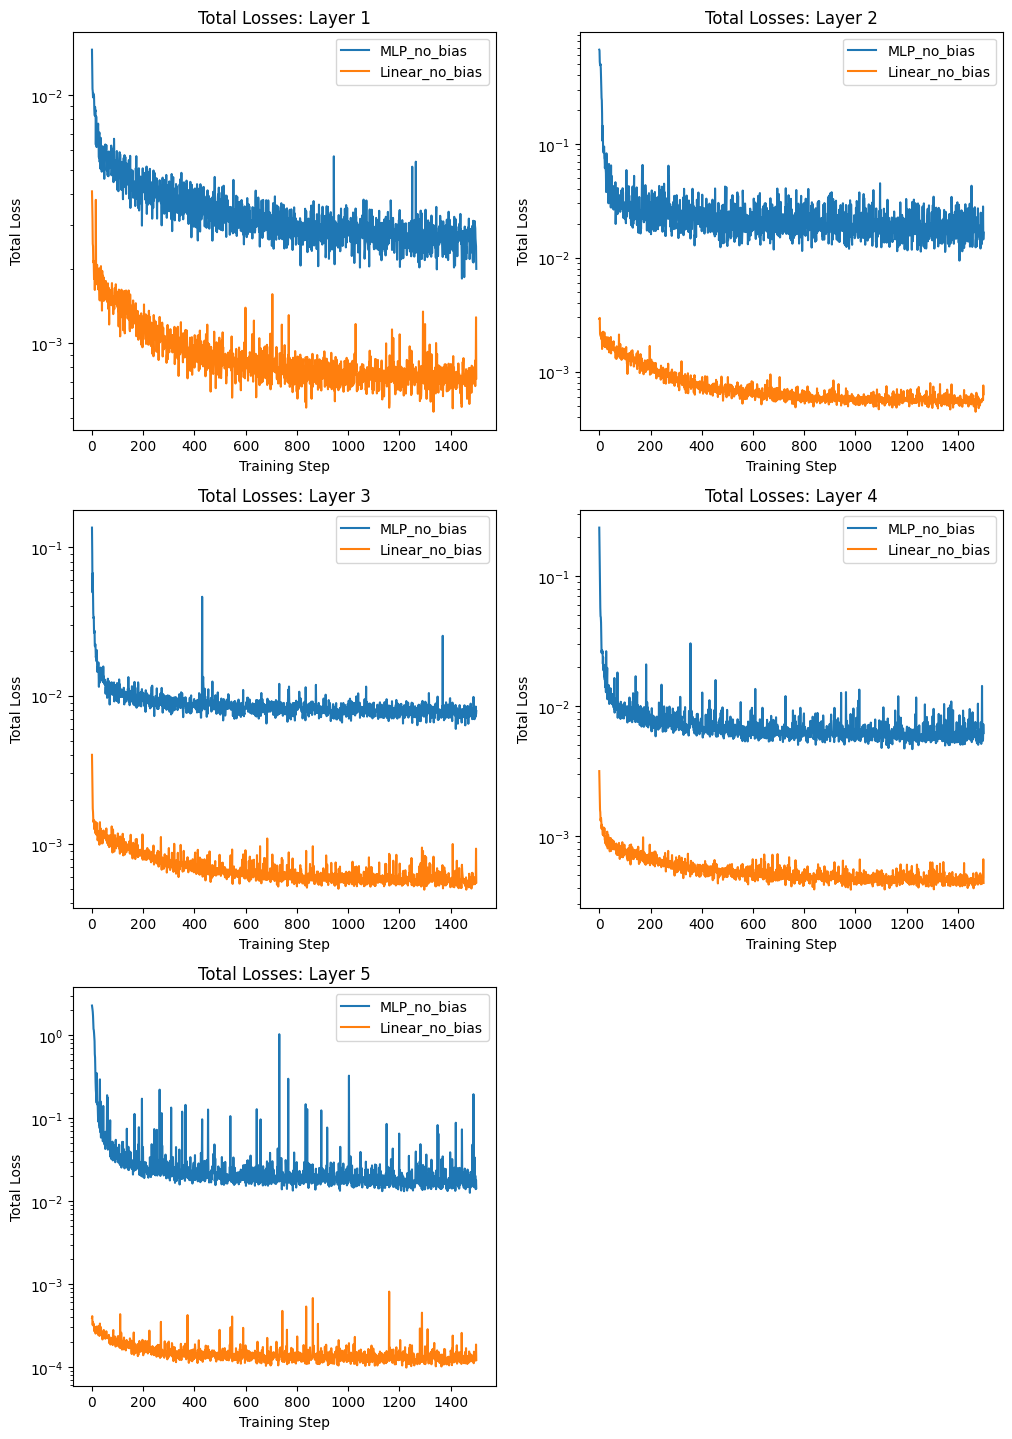

In [51]:
# Plot training curve for total loss
# Plot both losses
import matplotlib.pyplot as plt

num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)
    plt.title(f"Total Losses: Layer {layer+1}")
    # plt.plot(mlp_losses_no_bias[layer][0][::2])
    # plt.plot(linear_losses_no_bias[layer][0][::2])
    plt.plot(mlp_losses_no_bias_mse[layer][0][::2])
    plt.plot(linear_losses_no_bias_mse[layer][0][::2])
    # plt.plot(mlp_losses_no_bias_l1[layer][0][::2])
    # plt.plot(linear_losses_no_bias_l1[layer][0][::2])
    # if(layer ==2):
    #     # set max y to 0.05
    #     plt.ylim(0, 0.03)
    plt.legend(["MLP_no_bias", "Linear_no_bias"])
    plt.xlabel("Training Step")
    plt.ylabel("Total Loss")
    # y log
    plt.yscale('log')
plt.show()

In [72]:
# for i in range (100):
#     large_weights = (linear_weights_no_bias[0][0].linear.weight[i] > 0.0005).sum()
#     print(f"Large weights: {large_weights}")
for i in range (100):
    large_weights = (mlp_weights_no_bias[0][0].linear.weight[i] > 0.0004).sum()
    print(f"Large weights: {large_weights}")

Large weights: 19
Large weights: 112
Large weights: 36
Large weights: 6
Large weights: 16
Large weights: 9
Large weights: 12
Large weights: 5
Large weights: 2
Large weights: 6
Large weights: 4
Large weights: 21
Large weights: 6
Large weights: 5
Large weights: 8
Large weights: 106
Large weights: 8
Large weights: 8
Large weights: 9
Large weights: 7
Large weights: 332
Large weights: 6
Large weights: 39
Large weights: 7
Large weights: 55
Large weights: 24
Large weights: 86
Large weights: 35
Large weights: 1
Large weights: 279
Large weights: 8
Large weights: 42
Large weights: 10
Large weights: 328
Large weights: 7
Large weights: 374
Large weights: 9
Large weights: 3
Large weights: 7
Large weights: 10
Large weights: 9
Large weights: 16
Large weights: 5
Large weights: 7
Large weights: 4
Large weights: 19
Large weights: 8
Large weights: 6
Large weights: 5
Large weights: 49
Large weights: 126
Large weights: 8
Large weights: 8
Large weights: 7
Large weights: 5
Large weights: 12
Large weights: 4


In [27]:
# Save the sparse weight models
dir = "sparse_weights"
for layer in range(num_layers):
    torch.save(mlp_weights_no_bias[layer][0], f"{dir}/mlp_weights_no_bias_{layer}.pt")
    torch.save(linear_weights_no_bias[layer][0], f"{dir}/linear_weights_no_bias_{layer}.pt")

In [47]:
linear_losses_no_bias[3][0][-1]

0.5426863431930542

## Sweep batch-size

In [14]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
linear_weights_no_bias = []

mlp_optimizers_no_bias = []
linear_optimizers_no_bias = []
batch_sizes = 4
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    linear_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    linear_optimizers_no_bias.append([])
    for batch_sizes_ind in range(batch_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
        linear_weights_no_bias[-1].append(linear_no_bias(num_features, output_size=num_linear_features))
        linear_optimizers_no_bias[-1].append(Adam(linear_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [19]:
linear_weights_no_bias[0]

[linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 ),
 linear_no_bias(
   (linear): Linear(in_features=3072, out_features=853, bias=False)
 )]

In [24]:

def train_sparse_model_batch_size(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, batch_size_lists, feature_ind, l1_alpha = 8e-4):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for batch_ind, batch_size in enumerate(batch_size_lists):
                # print(f"len of sparseweights: {len(sparse_weights[cache_name_ind])}")
                # print(f"batch ind: {batch_ind}")
                sparse_weight = sparse_weights[cache_name_ind][batch_ind].to(device)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                # Split the batch (input/output_internal_activations) into batch_size amount of chunks
                batched_input_internal_activations = torch.split(input_internal_activations, batch_size, dim=0)
                batched_output_internal_activations = torch.split(output_internal_activations, batch_size, dim=0)
                for b_ind in range(batch_size):
                    x_hat = sparse_weight(batched_input_internal_activations[b_ind])

                    indexed_x_hat = x_hat
                    indexed_output_internal_activations = batched_output_internal_activations[b_ind].index_select(dim=1, index=alive_and_selected_features)
                    
                    # Divide MSE_loss by normalization factor
                    mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                    l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                    # check if sparse_weight.linear2 exists
                    if hasattr(sparse_weight, "linear2"):
                        l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                        l1_loss /= 2
                    unweighted_loss = mse_loss + l1_loss
                    loss = mse_loss + l1_alpha * l1_loss

                    loss.backward()
                    optimizers[cache_name_ind][batch_ind].step()
                    optimizers[cache_name_ind][batch_ind].zero_grad()
                losses[cache_name_ind][batch_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][batch_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][batch_ind].append(l1_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item()} | L1 Loss: {l1_loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > 100:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1
batch_size_lists = [1,2,4,8]
linear_losses_no_bias, linear_losses_no_bias_mse, linear_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, linear_weights_no_bias, autoencoders, cache_names, linear_optimizers_no_bias, batch_size_lists, linear_features)
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1 = train_sparse_model_batch_size(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, batch_size_lists, mlp_features)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01108487043529749 | L1 Loss: 16.406333923339844
Layers: 0 | l1 alpha MSE Loss: 0.0072320373728871346 | L1 Loss: 14.048239707946777
Layers: 0 | l1 alpha MSE Loss: 0.0020126362796872854 | L1 Loss: 12.339141845703125
Layers: 0 | l1 alpha MSE Loss: 0.009344893507659435 | L1 Loss: 11.838696479797363
Layers: 1 | l1 alpha MSE Loss: 0.0035510286688804626 | L1 Loss: 27.70962905883789
Layers: 1 | l1 alpha MSE Loss: 0.0020851348526775837 | L1 Loss: 24.861005783081055
Layers: 1 | l1 alpha MSE Loss: 0.0062055205926299095 | L1 Loss: 19.660966873168945
Layers: 1 | l1 alpha MSE Loss: 0.004365518223494291 | L1 Loss: 11.681697845458984
Layers: 2 | l1 alpha MSE Loss: 0.13593453168869019 | L1 Loss: 27.70911979675293
Layers: 2 | l1 alpha MSE Loss: 0.0008077995735220611 | L1 Loss: 24.885446548461914
Layers: 2 | l1 alpha MSE Loss: 0.003832042682915926 | L1 Loss: 19.810791015625
Layers: 2 | l1 alpha MSE Loss: 0.002782099414616823 | L1 Loss: 11.939117431640625
Layers: 3 | l1 al

  0%|          | 1/10963 [00:00<1:37:14,  1.88it/s]

Layers: 4 | l1 alpha MSE Loss: 0.00012494964175857604 | L1 Loss: 19.63352394104004
Layers: 4 | l1 alpha MSE Loss: 0.00017453737382311374 | L1 Loss: 11.440549850463867


  1%|          | 100/10963 [00:41<1:19:26,  2.28it/s]

Layers: 0 | l1 alpha MSE Loss: 0.01148004736751318 | L1 Loss: 10.907217025756836
Layers: 0 | l1 alpha MSE Loss: 0.0001482250081608072 | L1 Loss: 10.433944702148438
Layers: 0 | l1 alpha MSE Loss: 0.0012853475054726005 | L1 Loss: 9.779388427734375
Layers: 0 | l1 alpha MSE Loss: 0.0033413521014153957 | L1 Loss: 8.776857376098633
Layers: 1 | l1 alpha MSE Loss: 0.000371765490854159 | L1 Loss: 0.9866786599159241
Layers: 1 | l1 alpha MSE Loss: 0.0012366654118523002 | L1 Loss: 0.6081542372703552
Layers: 1 | l1 alpha MSE Loss: 0.0004279441200196743 | L1 Loss: 0.5737454891204834
Layers: 1 | l1 alpha MSE Loss: 0.0023512302432209253 | L1 Loss: 0.5838077664375305
Layers: 2 | l1 alpha MSE Loss: 0.004182395990937948 | L1 Loss: 1.3501023054122925
Layers: 2 | l1 alpha MSE Loss: 0.0013818911975249648 | L1 Loss: 0.6858962774276733
Layers: 2 | l1 alpha MSE Loss: 0.0009942067554220557 | L1 Loss: 0.6465616822242737
Layers: 2 | l1 alpha MSE Loss: 0.0009721997193992138 | L1 Loss: 0.6518599987030029
Layers: 3 

  1%|          | 101/10963 [00:42<1:15:14,  2.41it/s]

Layers: 3 | l1 alpha MSE Loss: 0.0006381093407981098 | L1 Loss: 0.49096494913101196
Layers: 3 | l1 alpha MSE Loss: 0.0010913248406723142 | L1 Loss: 0.4924597144126892
Layers: 4 | l1 alpha MSE Loss: 0.013101235963404179 | L1 Loss: 0.4127342700958252
Layers: 4 | l1 alpha MSE Loss: 0.00029025247204117477 | L1 Loss: 0.38380274176597595
Layers: 4 | l1 alpha MSE Loss: 0.0003766260633710772 | L1 Loss: 0.3801612854003906
Layers: 4 | l1 alpha MSE Loss: 0.00013140718510840088 | L1 Loss: 0.3779260516166687


  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.16319960355758667 | L1 Loss: 27.716306686401367
Layers: 0 | l1 alpha MSE Loss: 0.01577700302004814 | L1 Loss: 25.64874267578125
Layers: 0 | l1 alpha MSE Loss: 0.0018990858225151896 | L1 Loss: 22.068191528320312
Layers: 0 | l1 alpha MSE Loss: 0.009333942085504532 | L1 Loss: 15.491870880126953
Layers: 1 | l1 alpha MSE Loss: 33.485992431640625 | L1 Loss: 27.69315528869629
Layers: 1 | l1 alpha MSE Loss: 0.020819811150431633 | L1 Loss: 25.687313079833984
Layers: 1 | l1 alpha MSE Loss: 0.04993215203285217 | L1 Loss: 22.296546936035156
Layers: 1 | l1 alpha MSE Loss: 0.05541082099080086 | L1 Loss: 17.264114379882812
Layers: 2 | l1 alpha MSE Loss: 2.2771458625793457 | L1 Loss: 27.662487030029297
Layers: 2 | l1 alpha MSE Loss: 0.04349406063556671 | L1 Loss: 25.71468734741211
Layers: 2 | l1 alpha MSE Loss: 0.05708504095673561 | L1 Loss: 22.483768463134766
Layers: 2 | l1 alpha MSE Loss: 0.05565192177891731 | L1 Loss: 17.82221221923828
Layers: 3 | l1 alpha MSE Loss:

  0%|          | 1/10963 [00:01<3:46:29,  1.24s/it]

Layers: 4 | l1 alpha MSE Loss: 1.7191894054412842 | L1 Loss: 14.76616096496582


  1%|          | 100/10963 [02:01<4:08:57,  1.38s/it]

Layers: 0 | l1 alpha MSE Loss: 0.018970543518662453 | L1 Loss: 5.650140762329102
Layers: 0 | l1 alpha MSE Loss: 0.004428334999829531 | L1 Loss: 4.917581081390381
Layers: 0 | l1 alpha MSE Loss: 0.0451621413230896 | L1 Loss: 4.817112922668457
Layers: 0 | l1 alpha MSE Loss: 0.0006021808367222548 | L1 Loss: 4.370416641235352
Layers: 1 | l1 alpha MSE Loss: 0.0664447620511055 | L1 Loss: 11.791213035583496
Layers: 1 | l1 alpha MSE Loss: 0.27335211634635925 | L1 Loss: 15.092637062072754
Layers: 1 | l1 alpha MSE Loss: 1.1110835075378418 | L1 Loss: 17.98584747314453
Layers: 1 | l1 alpha MSE Loss: 0.01055885013192892 | L1 Loss: 18.779285430908203
Layers: 2 | l1 alpha MSE Loss: 0.02451123669743538 | L1 Loss: 7.997378826141357
Layers: 2 | l1 alpha MSE Loss: 0.014653343707323074 | L1 Loss: 8.486013412475586
Layers: 2 | l1 alpha MSE Loss: 0.04060237854719162 | L1 Loss: 10.007165908813477
Layers: 2 | l1 alpha MSE Loss: 0.007704219780862331 | L1 Loss: 9.779840469360352
Layers: 3 | l1 alpha MSE Loss: 0.

  1%|          | 101/10963 [02:02<4:17:13,  1.42s/it]

Layers: 4 | l1 alpha MSE Loss: 1.088895559310913 | L1 Loss: 18.488967895507812


  1%|          | 101/10963 [02:04<3:42:20,  1.23s/it]


## Sweep over MLP

In [16]:
    
class mlp_no_bias(nn.Module):
    def __init__(self, input_size, hidden_layer_size=None):
        super().__init__()
        if hidden_layer_size is None:
            hidden_layer_size = input_size
        self.linear = nn.Linear(input_size, hidden_layer_size, bias=False)
        self.linear2 = nn.Linear(hidden_layer_size, input_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

mlp_weights_no_bias = []

mlp_optimizers_no_bias = []
hidden_layer_sizes = 13
for auto_ind in range(len(autoencoders)//2): # This is per layer
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for hidd_layer_s in range(hidden_layer_sizes):
        mlp_weights_no_bias[-1].append(mlp_no_bias(num_features, 2**(hidd_layer_s+1)))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))

In [17]:
def train_sparse_model_hidden_unit(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers):
    mse = nn.MSELoss()
    batch_size = 32
    hidden_unit_models = len(sparse_weights[0])
    losses = [[[] for _ in range(hidden_unit_models)] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for hidden_unit_m in range(hidden_unit_models):
                sparse_weight = sparse_weights[cache_name_ind][hidden_unit_m].to(device)
                x_hat = sparse_weight(input_internal_activations)

                # loss = mse(x_hat, output_internal_activations)
                current_alive_features_ind = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0].to(device)
                indexed_x_hat = x_hat.index_select(dim=1, index=current_alive_features_ind)
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=current_alive_features_ind)
                
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations)
                loss = mse_loss

                loss.backward()
                optimizers[cache_name_ind][hidden_unit_m].step()
                optimizers[cache_name_ind][hidden_unit_m].zero_grad()
                losses[cache_name_ind][hidden_unit_m].append(loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 300 == 0:
                    print(f"Layers: {cache_name_ind} | MSE Loss: {loss.item()}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, current_alive_features_ind, mse_loss
                torch.cuda.empty_cache()

        if i > 300:
            # Stop training after 1000 batches
            break
    return losses
mlp_losses_no_bias = train_sparse_model_hidden_unit(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | MSE Loss: 0.005501554347574711
Layers: 0 | MSE Loss: 0.00553678534924984
Layers: 0 | MSE Loss: 0.005442761350423098
Layers: 0 | MSE Loss: 0.005443949718028307
Layers: 0 | MSE Loss: 0.0054717641323804855
Layers: 0 | MSE Loss: 0.00543338805437088
Layers: 0 | MSE Loss: 0.005409144330769777
Layers: 0 | MSE Loss: 0.005405251402407885
Layers: 0 | MSE Loss: 0.005431877449154854
Layers: 0 | MSE Loss: 0.005403609946370125
Layers: 0 | MSE Loss: 0.0054214466363191605
Layers: 0 | MSE Loss: 0.005428903270512819
Layers: 0 | MSE Loss: 0.005418367218226194
Layers: 1 | MSE Loss: 0.06880893558263779
Layers: 1 | MSE Loss: 0.06885495781898499
Layers: 1 | MSE Loss: 0.06853997707366943
Layers: 1 | MSE Loss: 0.06845316290855408
Layers: 1 | MSE Loss: 0.06851335614919662
Layers: 1 | MSE Loss: 0.0686269998550415
Layers: 1 | MSE Loss: 0.06857927143573761
Layers: 1 | MSE Loss: 0.0686480700969696
Layers: 1 | MSE Loss: 0.06843666732311249
Layers: 1 | MSE Loss: 0.06871131807565689
Layers: 1 | MSE Loss: 0

  0%|          | 1/10963 [00:02<8:23:12,  2.75s/it]

Layers: 4 | MSE Loss: 4.555083751678467


  3%|▎         | 300/10963 [13:46<8:11:05,  2.76s/it] 

Layers: 0 | MSE Loss: 0.004248362500220537
Layers: 0 | MSE Loss: 0.004250658210366964
Layers: 0 | MSE Loss: 0.0042420318350195885
Layers: 0 | MSE Loss: 0.00382217182777822
Layers: 0 | MSE Loss: 0.0032627990003675222
Layers: 0 | MSE Loss: 0.002748209750279784
Layers: 0 | MSE Loss: 0.002356917131692171
Layers: 0 | MSE Loss: 0.0019626086577773094
Layers: 0 | MSE Loss: 0.0015897859120741487
Layers: 0 | MSE Loss: 0.00132092391140759
Layers: 0 | MSE Loss: 0.001136928447522223
Layers: 0 | MSE Loss: 0.0010089885909110308
Layers: 0 | MSE Loss: 0.001014913315884769
Layers: 1 | MSE Loss: 0.05118892341852188
Layers: 1 | MSE Loss: 0.049422748386859894
Layers: 1 | MSE Loss: 0.01966453343629837
Layers: 1 | MSE Loss: 0.01270791795104742
Layers: 1 | MSE Loss: 0.009349728003144264
Layers: 1 | MSE Loss: 0.008106575347483158
Layers: 1 | MSE Loss: 0.006919429171830416
Layers: 1 | MSE Loss: 0.005623080767691135
Layers: 1 | MSE Loss: 0.004562114365398884
Layers: 1 | MSE Loss: 0.003838918637484312
Layers: 1 |

  3%|▎         | 301/10963 [13:49<8:10:50,  2.76s/it]

Layers: 4 | MSE Loss: 0.06059036776423454


  3%|▎         | 301/10963 [13:52<8:11:25,  2.77s/it]


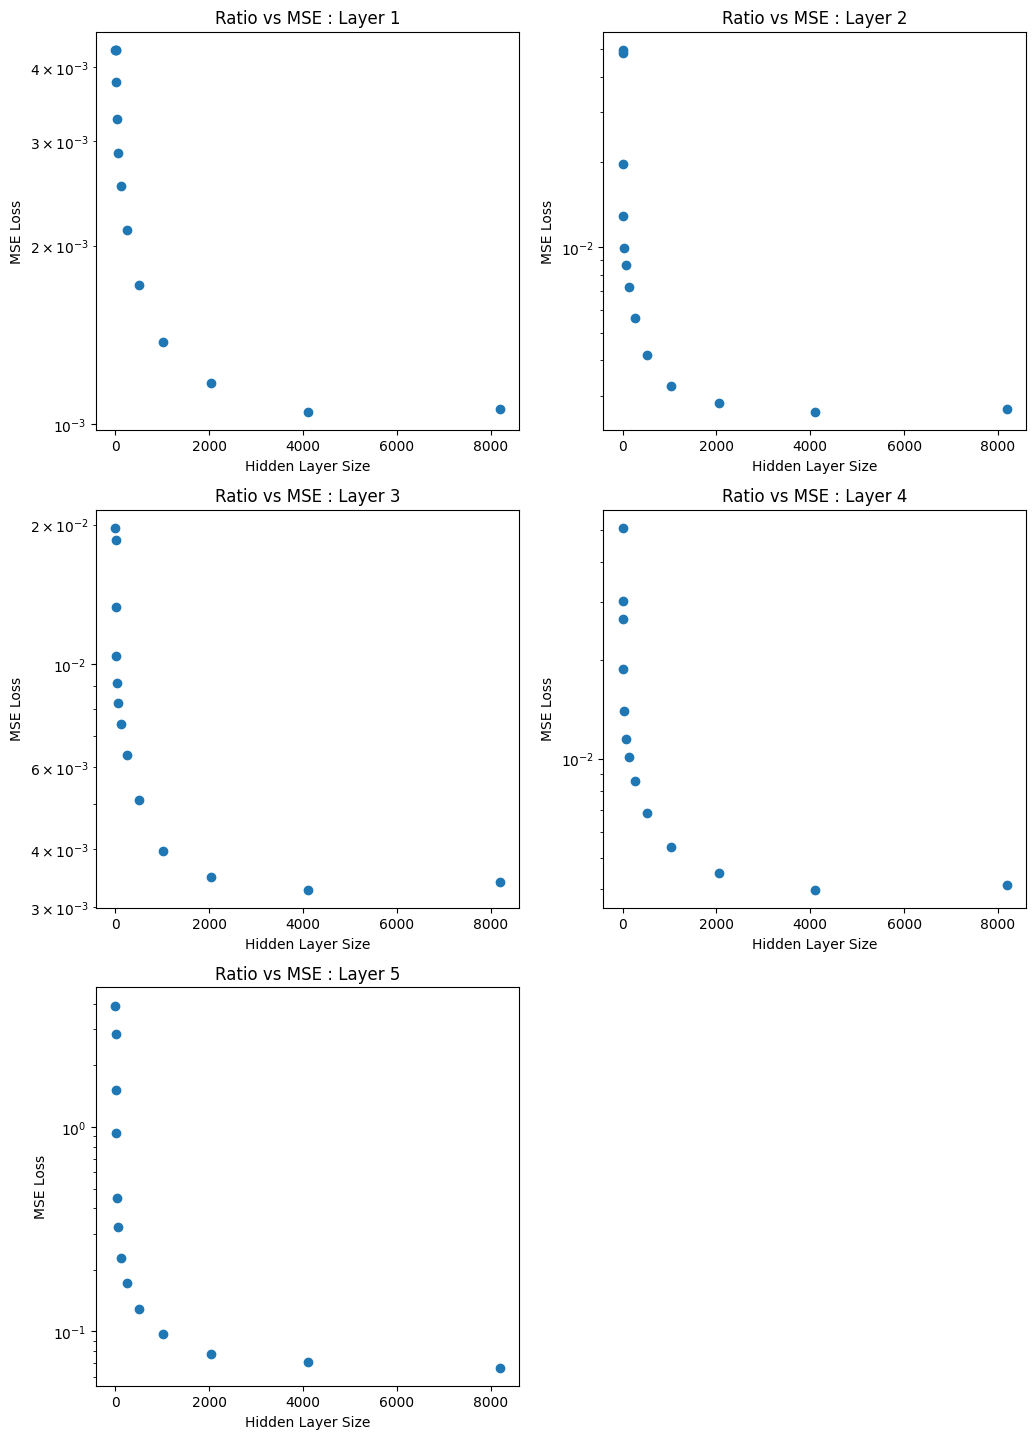

In [20]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt

num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

hidden_layer_sizes
mlp_losses_last = np.zeros((num_layers, hidden_layer_sizes))
for layer in range(num_layers):
    for hidden_layer_s in range(hidden_layer_sizes):
        mlp_losses_last[layer, hidden_layer_s] = mlp_losses_no_bias[layer][hidden_layer_s][-1]

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed
ratios = [2**(i+1) for i in range(hidden_layer_sizes)]
for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"Ratio vs MSE : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_losses_last[layer]
    # Plot
    plt.plot(ratios, mlp_l1_loss, 'o')
    plt.yscale('log')
    # plt.xscale('log')
    # plt.legend()
    plt.ylabel("MSE Loss")
    plt.xlabel("Hidden Layer Size")
plt.show()

In [13]:
ratios

[2, 4, 8, 16, 32, 64, 128, 256]

In [31]:
len(mlp_losses_no_bias[0][0])

5

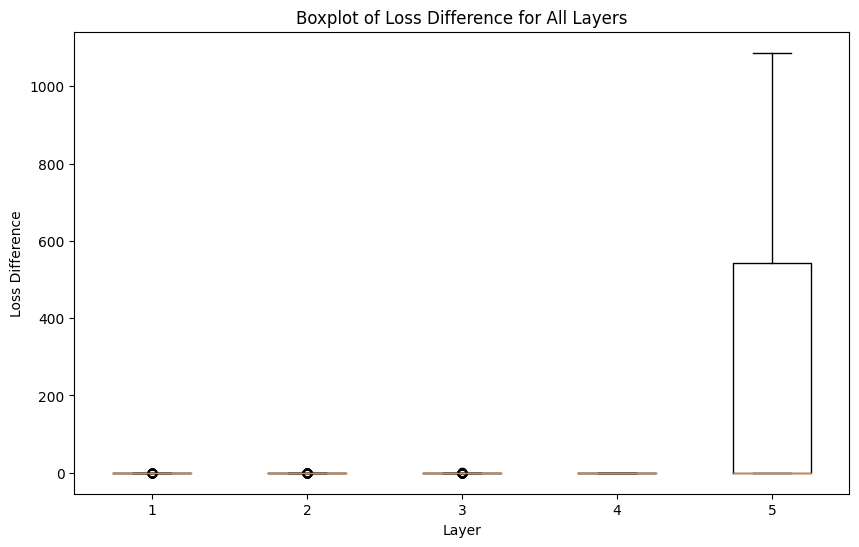

In [19]:
import matplotlib.pyplot as plt

# Collect all loss_diff data for each layer into a list
all_layers_loss_diff = [loss_diff[layer] for layer in range(len(loss_diff))]

plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(all_layers_loss_diff)
plt.title("Boxplot of Loss Difference for All Layers")
plt.xlabel("Layer")
plt.ylabel("Loss Difference")

plt.show()

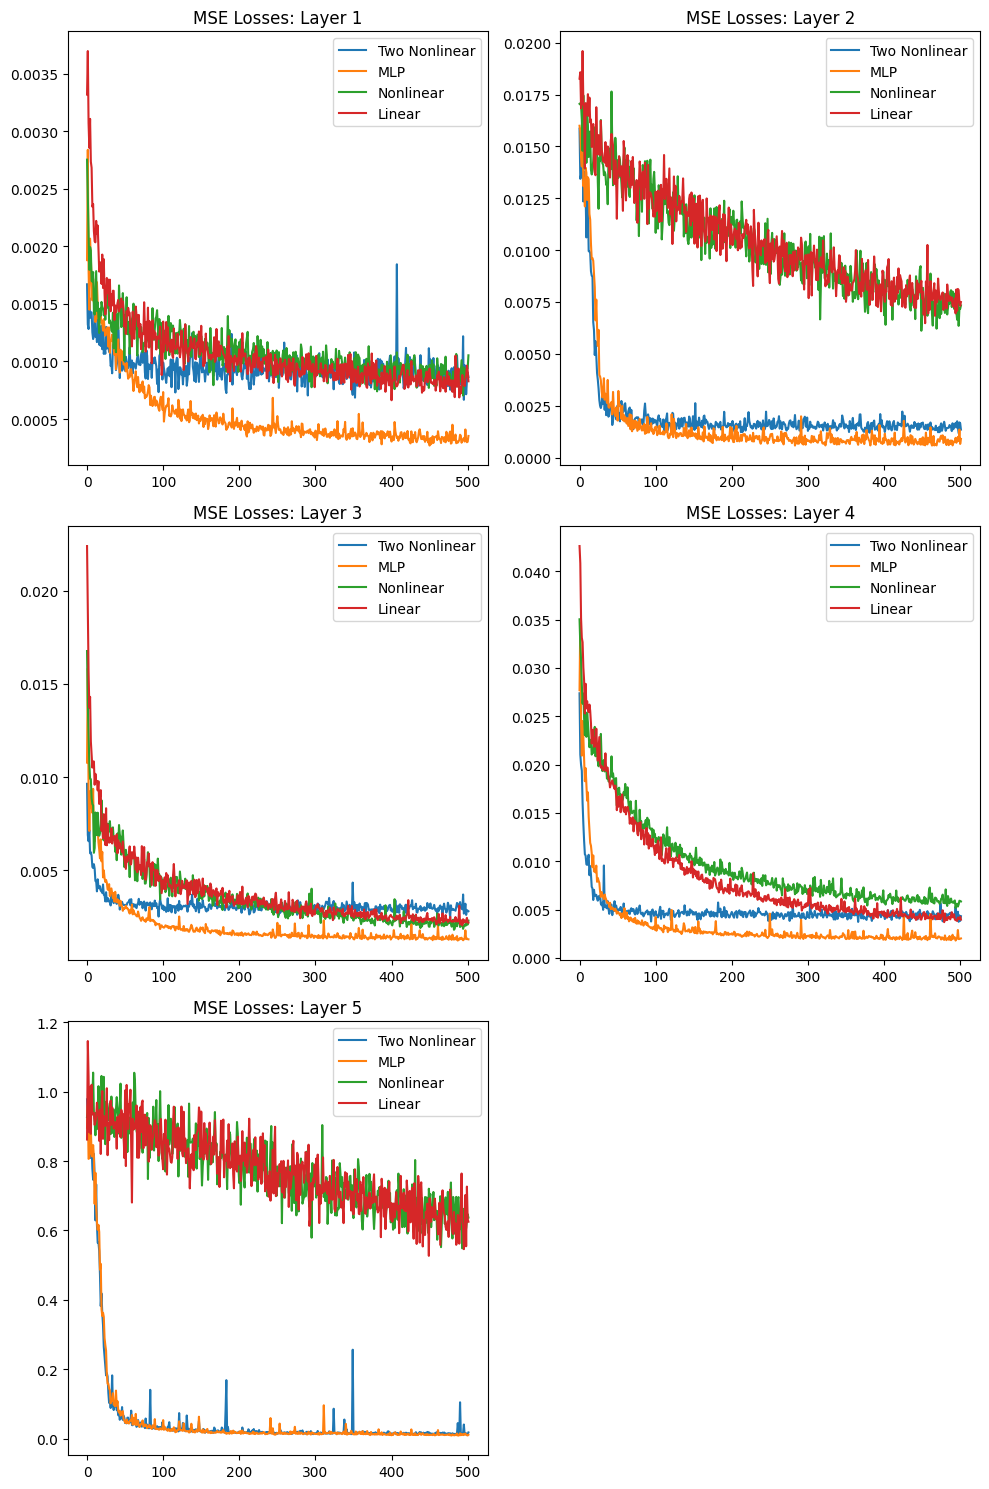

In [15]:
import matplotlib.pyplot as plt

num_layers = len(two_nonlinear_losses)
num_columns = 2  # You can adjust this based on how many plots you want per row
num_rows = (num_layers + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(10, 5 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    plt.subplot(num_rows, num_columns, layer + 1)  # Create a subplot for each layer
    plt.title(f"MSE Losses: Layer {layer+1}")
    plt.plot(two_nonlinear_losses[layer], label="Two Nonlinear")
    plt.plot(mlp_losses[layer], label="MLP")
    plt.plot(nonlinear_losses[layer], label="Nonlinear")
    plt.plot(linear_losses[layer], label="Linear")
    plt.legend()

plt.tight_layout()
plt.show()


In [24]:
nonlinear_losses, linear_loss

(array([0.00114306, 0.02376839, 0.00199088, 0.00503561, 0.70069301]),
 array([0.00112041, 0.02399791, 0.00216295, 0.00460967, 0.70566905]))

In [53]:
from baukit import TraceDict
mse = nn.MSELoss()
l1_alpha = 1e-3
datapoints = dataset.num_rows
batch_size = 32
losses = np.zeros(len(sparse_weights))
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(dl):
        batch = batch.to(device)
        with torch.no_grad():
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        # # Get every 2 cache names (since they're matched up)
        for cache_name_ind in range(len(cache_names)//2):
            sparse_weight = sparse_weights[cache_name_ind]

            input_cache_name = cache_names[(cache_name_ind*2)]
            output_cache_name = cache_names[(cache_name_ind*2)+1]
            input_autoencoder = autoencoders[(cache_name_ind*2)]
            output_autoencoder = autoencoders[(cache_name_ind*2)+1]
            input_activations = ret[input_cache_name].output
            output_activations = ret[output_cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(input_activations, tuple)):
                input_activations = input_activations[0]
            if(isinstance(output_activations, tuple)):
                output_activations = output_activations[0]
            # Rearrange to (batch_size*seq_length, num_features)
            input_internal_activations = rearrange(input_activations, "b s n -> (b s) n" )
            output_internal_activations = rearrange(output_activations, "b s n -> (b s) n" )
            # Encode
            input_internal_activations = input_autoencoder.encode(input_internal_activations)
            output_internal_activations = output_autoencoder.encode(output_internal_activations)
            # Encode
            x_hat = sparse_weights[cache_name_ind](input_internal_activations)
            # Get loss
            loss = mse(x_hat, output_internal_activations)
            l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
            # loss += l1_alpha*l1_loss
            # Backprop
            loss.backward()
            optimizers[cache_name_ind].step()
            optimizers[cache_name_ind].zero_grad()
            losses[cache_name_ind] = loss.item()
            if(i%50==0):
                print(f"Layers: {cache_name_ind} |  MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")


Layers: 0 |  MSE Loss: 0.0032902932725846767 | L1 Loss: 27.721176147460938
Layers: 1 |  MSE Loss: 0.045880552381277084 | L1 Loss: 27.712087631225586
Layers: 2 |  MSE Loss: 0.02548954077064991 | L1 Loss: 27.71087646484375
Layers: 3 |  MSE Loss: 0.0651974007487297 | L1 Loss: 27.717008590698242
Layers: 4 |  MSE Loss: 0.8611162900924683 | L1 Loss: 27.709190368652344
Layers: 0 |  MSE Loss: 0.001719774678349495 | L1 Loss: 24.83885955810547
Layers: 1 |  MSE Loss: 0.038391195237636566 | L1 Loss: 26.483190536499023
Layers: 2 |  MSE Loss: 0.0042221806943416595 | L1 Loss: 28.59328269958496
Layers: 3 |  MSE Loss: 0.02699713036417961 | L1 Loss: 28.991947174072266
Layers: 4 |  MSE Loss: 0.8554728031158447 | L1 Loss: 29.95911979675293
Layers: 0 |  MSE Loss: 0.0017383686499670148 | L1 Loss: 24.861730575561523
Layers: 1 |  MSE Loss: 0.035102322697639465 | L1 Loss: 26.954181671142578
Layers: 2 |  MSE Loss: 0.0031695878133177757 | L1 Loss: 29.906362533569336
Layers: 3 |  MSE Loss: 0.018583638593554497 | 

In [55]:
losses_mlp, losses

# See if the top weights have high cosine similarity between the two

In [13]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
# for f_out, f_in in indices:
    # Find the cosine similarity between these two vectors

dict_in = autoencoders[0].get_learned_dict()
dict_out = autoencoders[1].get_learned_dict()


In [1]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [24]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3108, 0.3100, 0.3035, 0.3032, 0.3001, 0.2986, 0.2986, 0.2979, 0.2974,
         0.2940], device='cuda:0'),
 tensor([2390, 2863, 2390, 1224, 2863, 1224, 1582, 2863, 1582, 1582],
        device='cuda:0'),
 tensor([3028, 3028,  247,  247,  887,  887,  887, 1904,  247,   67],
        device='cuda:0'))

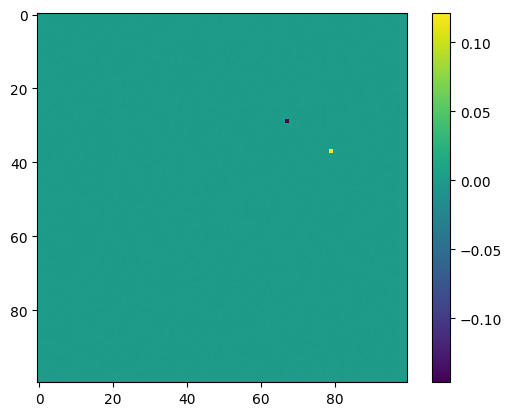

In [25]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [33]:
threshold_pos = 0.1
threshold_neg = -0.1
total_weights = Sparse_nonlinear.linear.weight.numel()
(Sparse_nonlinear.linear.weight > threshold_pos).count_nonzero() / total_weights, (Sparse_nonlinear.linear.weight < threshold_neg).count_nonzero() / total_weights, total_weights

(tensor(0.0002, device='cuda:0'), tensor(0.0001, device='cuda:0'), 9437184)

In [35]:
indices = (Sparse_nonlinear.linear.weight > 0.1).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [  11,  596],
         [  11, 1184],
         ...,
         [3059, 2127],
         [3059, 3066],
         [3065, 2497]], device='cuda:0'),
 tensor([0.1686, 0.1715, 0.1995,  ..., 0.2472, 0.1418, 0.1529], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [38]:
indices[:10]

tensor([[   1, 2191],
        [  11,  596],
        [  11, 1184],
        [  11, 2676],
        [  14, 2468],
        [  19, 1166],
        [  20,  719],
        [  28,  232],
        [  28,  662],
        [  29, 1404]], device='cuda:0')

In [39]:
indices[10:20]

tensor([[  31, 2115],
        [  31, 2399],
        [  31, 3014],
        [  34, 2422],
        [  37,   79],
        [  37, 1885],
        [  89, 1323],
        [ 103,  837],
        [ 103, 2310],
        [ 105, 1565]], device='cuda:0')

In [40]:
indices[20:30]

tensor([[ 105, 2002],
        [ 105, 2697],
        [ 106,   67],
        [ 106,  146],
        [ 106,  189],
        [ 106,  247],
        [ 106,  330],
        [ 106,  344],
        [ 106,  458],
        [ 106,  690]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

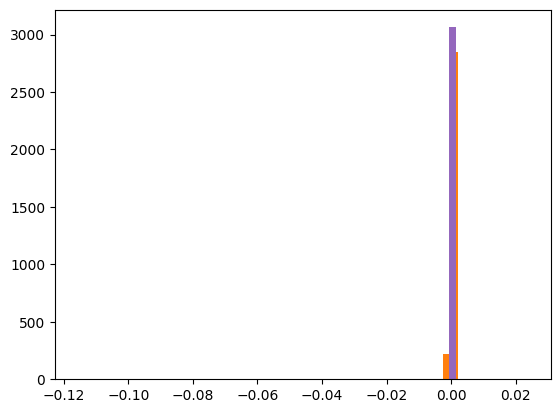

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

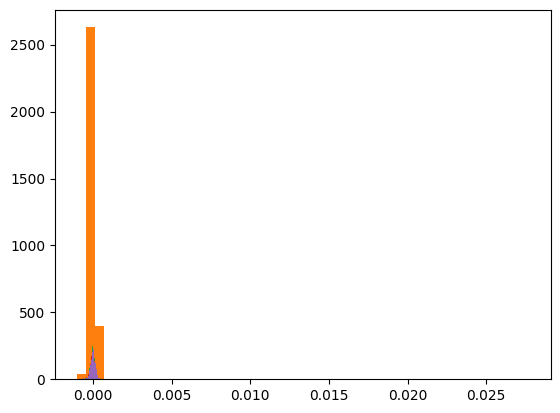

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()